In [1]:
# banks acquire and lose customer every now and then --> customer population changes. The future customers are also more likely to look like the new population than the old population, which were used to train the model. 
# if the new population is so much different to the previous population --> need to redevelop the entire model. 
# PD model is often reassessed on a schedule (every 6 months or a year)
# alternatively, can redevelop the model for every 50,000 or 100,000 new data point. 

# Population Stability Index (PSI)

In [2]:
# Population Stability Index (PSI) determines whether the new data is too different than from the original ones.
# PSI = 0 --> no difference between 2 populations
# PSI < 0.1 --> little to no difference between 2 populations
# 0.1 < PSI < 0.25 --> little difference between 2 populations, investigate the reason, but no action for the model
# PSI > 0.25 --> big difference between 2 populations, investigation is required, model might have to be redeveloped
# PSI = 1 --> 2 populations are absolutely different

# usually, if there is a significant change in one of the features, the entire model has to be rebuilt. 
# PSI should be calculated for both independent variable and dependent variables (good_bad & credit score) --> to make see if distribution of the score itself has changed.

In [3]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os

import matplotlib.pyplot as plt
import seaborn as sns   #seaborn is a nice skin for matplotlib
sns.set()

In [4]:
path_datamart = os.path.expanduser( '~\Google Drive\Coding\Python\Credit Risk Modeling in Python\Datamart' )
inputs_train_csv = pd.read_csv(os.path.join(path_datamart, 'inputs_train.csv'), index_col=0)    # original, actual population
targets_train_csv = pd.read_csv(os.path.join(path_datamart, 'targets_train.csv'), index_col=0)  
inputs_test_csv = pd.read_csv(os.path.join(path_datamart, 'inputs_test.csv'), index_col=0)
targets_test_csv = pd.read_csv(os.path.join(path_datamart, 'targets_test.csv'), index_col=0)

In [5]:
loan_data = pd.read_csv(os.path.join(path_datamart, 'loan_data_2015.csv'), index_col=0) # name it loan_data so that can reuse the code in the preprocessing step
loan_data_backup = loan_data.copy() # create a back up for the new loan

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
loan_data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
id,,,,,,,,,,,,,,,,,,,,,
68444620,73334399,35000,35000,35000.0,60 months,11.99,778.38,C,C1,Foreign Service Officer,...,35367.0,49.3,0.0,1.0,5020.0,40.1,52200.0,1.0,4.0,0.0
68547583,73437441,8650,8650,8650.0,36 months,5.32,260.50,A,A1,Associate Consultant,...,24041.0,88.8,0.0,3.0,3081.0,57.9,26800.0,1.0,0.0,5.0
67849662,72708407,4225,4225,4225.0,36 months,14.85,146.16,C,C5,mechanic,...,3830.0,21.9,0.0,0.0,367.0,22.4,4300.0,0.0,0.0,0.0
68506885,73396712,10000,10000,10000.0,60 months,11.99,222.40,C,C1,CARDIOVASCULAR TECH,...,35354.0,75.5,1.0,1.0,3118.0,67.4,14200.0,1.0,1.0,1.0
68341763,72928789,20000,20000,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,10827.0,72.8,0.0,2.0,2081.0,64.7,14000.0,2.0,5.0,1.0


In [7]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421094 entries, 68444620 to 36271262
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    421094 non-null  int64  
 1   loan_amnt                    421094 non-null  int64  
 2   funded_amnt                  421094 non-null  int64  
 3   funded_amnt_inv              421094 non-null  float64
 4   term                         421094 non-null  object 
 5   int_rate                     421094 non-null  float64
 6   installment                  421094 non-null  float64
 7   grade                        421094 non-null  object 
 8   sub_grade                    421094 non-null  object 
 9   emp_title                    397220 non-null  object 
 10  emp_length                   397277 non-null  object 
 11  home_ownership               421094 non-null  object 
 12  annual_inc                   421094 non-null  flo

## preprocessing data

In [8]:
# copy codes from "Data Explore, Data Prep" notebook: From data cleansing until the end. 
# no need to split train and test data set
# NOTE: homeownership data has changed 
# NOTE: address state has another 2 missing values: IA and ID

### from string to numeric

In [9]:
loan_data['emp_length'].unique()  #employment length have 'year' string in the value 

array(['10+ years', '< 1 year', '5 years', '3 years', '4 years', nan,
       '2 years', '8 years', '9 years', '1 year', '6 years', '7 years'],
      dtype=object)

In [10]:
# clean up employment length and store in different column
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years','')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('years','')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year',str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('year','')
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])        #convert string to numeric
loan_data['emp_length_int'].unique()

array([10.,  0.,  5.,  3.,  4., nan,  2.,  8.,  9.,  1.,  6.,  7.])

### from text to date

In [11]:
loan_data['earliest_cr_line']   #date like but stored as text

id
68444620    Feb-90
68547583    Jul-01
67849662    Jul-11
68506885    Dec-98
68341763    Aug-00
             ...  
36371250    Sep-04
36441262    Mar-74
36271333    Sep-03
36490806    Oct-03
36271262    Dec-01
Name: earliest_cr_line, Length: 421094, dtype: object

In [12]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format='%b-%y')  #convert to date. NOTE: when the year is old, it will assume the year 2000 instead of the year 1900 (e.g.: 1966 is converted to 2066)

### date difference

In [13]:
pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']   #compute time difference in days

id
68444620   10165 days
68547583    5997 days
67849662    2345 days
68506885    6940 days
68341763    6331 days
              ...    
36371250    4839 days
36441262   15981 days
36271333    5205 days
36490806    5175 days
36271262    5844 days
Name: earliest_cr_line_date, Length: 421094, dtype: timedelta64[ns]

In [14]:
loan_data['mths_since_earliest_cr_line'] = round(
    pd.to_numeric(
        (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1,'M')
    )
)   #compute time difference in months
loan_data['mths_since_earliest_cr_line'] 

id
68444620    334.0
68547583    197.0
67849662     77.0
68506885    228.0
68341763    208.0
            ...  
36371250    159.0
36441262    525.0
36271333    171.0
36490806    170.0
36271262    192.0
Name: mths_since_earliest_cr_line, Length: 421094, dtype: float64

In [15]:
loan_data['mths_since_earliest_cr_line'].describe() #NOTE: the minimum value is negative. Because of the 2000/1900 year conversion mentioned earlier

count    421094.000000
mean        227.354876
std          98.123989
min        -612.000000
25%         167.000000
50%         212.000000
75%         277.000000
max         587.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [16]:
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line'] < 0]   #inspect those negative month records

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
id,,,
68406292,Jan-57,2057-01-01,-469.0
68506307,Aug-64,2064-08-01,-560.0
68466525,Jul-68,2068-07-01,-607.0
67858278,Jan-65,2065-01-01,-565.0
68595008,Sep-64,2064-09-01,-561.0
...,...,...,...
38018510,Jun-68,2068-06-01,-606.0
37801699,Jan-66,2066-01-01,-577.0
37691363,Sep-68,2068-09-01,-609.0


In [17]:
loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] -= timedelta(days=365.25*100)  #deduct 1 century from those dates
loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0]    #inspect again

<ipython-input-17-5ec8335abffa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['earliest_cr_line_date'][loan_data['mths_since_earliest_cr_line'] < 0] -= timedelta(days=365.25*100)  #deduct 1 century from those dates


id
68406292   1957-01-01
68506307   1964-08-01
68466525   1968-07-01
67858278   1965-01-01
68595008   1964-09-01
              ...    
38018510   1968-06-01
37801699   1966-01-01
37691363   1968-09-01
37800901   1965-09-01
37600541   1963-04-01
Name: earliest_cr_line_date, Length: 1134, dtype: datetime64[ns]

In [18]:
loan_data['mths_since_earliest_cr_line'] = round(
    pd.to_numeric( 
        (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1,'M')
    )
)   #recompute compute time difference in months
loan_data['mths_since_earliest_cr_line'].describe() #double check that the minimum value is no longer negative

count    421094.000000
mean        230.586458
std          91.329014
min          61.000000
25%         168.000000
50%         212.000000
75%         278.000000
max         887.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [19]:
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months',''))
loan_data['term_int'].describe()

count    421094.000000
mean         43.860782
std          11.263533
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: term_int, dtype: float64

In [20]:
loan_data['issue_date'] = pd.to_datetime(loan_data['issue_d'], format='%b-%y')
loan_data['mths_since_issue_d'] = round(
    pd.to_numeric(
        (pd.to_datetime('2017-12-01') - loan_data['issue_date']) / np.timedelta64(1,'M')
    )
)
loan_data['mths_since_issue_d']

id
68444620    24.0
68547583    24.0
67849662    24.0
68506885    24.0
68341763    24.0
            ... 
36371250    35.0
36441262    35.0
36271333    35.0
36490806    35.0
36271262    35.0
Name: mths_since_issue_d, Length: 421094, dtype: float64

### create dummy variables. Discrete variables

In [21]:
pd.get_dummies(loan_data['grade'])  #use pd.get_dummies to generate dummy variables out of a variable
pd.get_dummies(loan_data['grade'], prefix='grade', prefix_sep=':')  #can use prefix and prefix separator to create better variable names

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
id,,,,,,,
68444620,0,0,1,0,0,0,0
68547583,1,0,0,0,0,0,0
67849662,0,0,1,0,0,0,0
68506885,0,0,1,0,0,0,0
68341763,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
36371250,0,1,0,0,0,0,0
36441262,0,1,0,0,0,0,0
36271333,0,0,0,1,0,0,0


In [22]:
list_dummies = [
    pd.get_dummies(loan_data['grade'], prefix='grade', prefix_sep=':'),
    pd.get_dummies(loan_data['sub_grade'], prefix='sub_grade', prefix_sep=':'),
    pd.get_dummies(loan_data['home_ownership'], prefix='home_ownership', prefix_sep=':'),
    pd.get_dummies(loan_data['verification_status'], prefix='verification_status', prefix_sep=':'),
    pd.get_dummies(loan_data['loan_status'], prefix='loan_status', prefix_sep=':'),
    pd.get_dummies(loan_data['purpose'], prefix='purpose', prefix_sep=':'),
    pd.get_dummies(loan_data['addr_state'], prefix='addr_state', prefix_sep=':'),
    pd.get_dummies(loan_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':')
]   #do the same for all other discrete variables & put them in a list

In [23]:
loan_data_dummies = pd.concat(list_dummies, axis=1)     #concat all data frames stored in the list, by column (axis=1)
loan_data_dummies

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,...,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w
id,,,,,,,,,,,,,,,,,,,,,
68444620,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68547583,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
67849662,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68506885,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
68341763,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36371250,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36441262,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36271333,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis=1)   #concat with the original loan data
loan_data.columns.values        #check all column names of the dataframe

array(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
   

### dealing with null

In [25]:
#check if data is null. Anything null is True (=1), not null is False (=0). Therefore can take the sum to find out how many null rows there are in each column
pd.options.display.max_rows = None
loan_data.isnull().sum()

member_id                                   0
loan_amnt                                   0
funded_amnt                                 0
funded_amnt_inv                             0
term                                        0
int_rate                                    0
installment                                 0
grade                                       0
sub_grade                                   0
emp_title                               23874
emp_length                              23817
home_ownership                              0
annual_inc                                  0
verification_status                         0
issue_d                                     0
loan_status                                 0
pymnt_plan                                  0
url                                         0
desc                                   421049
purpose                                     0
title                                     132
zip_code                          

In [26]:
pd.options.display.max_rows = 60
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)    #replace null value of column total revolving high limit with the funded amount. 
loan_data['total_rev_hi_lim'].isnull().sum()    #check if the sum if null still exist

0

In [27]:
loan_data['annual_inc'].isnull().sum()

0

In [28]:
loan_data['annual_inc'].mean()

76965.60620616739

In [29]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['annual_inc'].isnull().sum()

0

In [30]:
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

## PD Model

### define dependent variable as Good_Bad

In [31]:
loan_data['loan_status'].value_counts()  #count numbers of each value in column loan_status

Current               377553
Fully Paid             22984
Issued                  8460
Late (31-120 days)      4691
In Grace Period         3107
Charged Off             2773
Late (16-30 days)       1139
Default                  387
Name: loan_status, dtype: int64

In [32]:
loan_data['loan_status'].value_counts()/loan_data['loan_status'].count()    #probability of occurence of each value in coumn loan_status

Current               0.896600
Fully Paid            0.054582
Issued                0.020091
Late (31-120 days)    0.011140
In Grace Period       0.007378
Charged Off           0.006585
Late (16-30 days)     0.002705
Default               0.000919
Name: loan_status, dtype: float64

In [33]:
# define good_bad variable as 1 = good = not default. 0 = bad = default
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin([
    'Charged Off','Late (31-120 days)','Default','Does not meet the credit policy. Status:Charged Off'
])          #list all criteria that will be marked as default (bad)
, 0         #default (bad) will be assigned value of 0
, 1         #nondefault (good) will be assigned value of 1
)

### data preparation

In [34]:
sample_input_df = loan_data.drop('good_bad', axis=1)
sample_target_df = loan_data['good_bad'] 

#### Weight of Evidence (WoE)

##### discrete variable

###### example (before writing a function): compute Weight of Evidence, Information Value for grade variable

In [35]:
df1 = pd.concat(
    [sample_input_df['grade'], sample_target_df], 
    axis=1
)   #combine an independent variable with a dependent variable by column
df1.head()

,grade,good_bad
id,,
68444620,C,1
68547583,A,1
67849662,C,1
68506885,C,1
68341763,B,1


In [36]:
#since each good value is 1, while bad value is 0 --> taking the average will compute the proportion of good --> 1 minus that average will compute the proportion of bad
df1.groupby(
    df1.columns.values[0],      #group df1 by values of the first column 
    as_index=False              #do not use as index
)[df1.columns.values[1]].mean()

,grade,good_bad
0,A,0.996359
1,B,0.991097
2,C,0.982541
3,D,0.967488
4,E,0.956936
5,F,0.930529
6,G,0.904015


In [37]:
df1 = pd.concat(
    [
        df1.groupby(
            df1.columns.values[0],
            as_index=False
        )[df1.columns.values[1]].count(),
        df1.groupby(
            df1.columns.values[0],
            as_index=False
        )[df1.columns.values[1]].mean()
    ],
    axis=1 
)   #merge the 2 above into 1 dataframe
df1

,grade,good_bad,grade,good_bad
0,A,73335,A,0.996359
1,B,117606,B,0.991097
2,C,120567,C,0.982541
3,D,62654,D,0.967488
4,E,34948,E,0.956936
5,F,9817,F,0.930529
6,G,2167,G,0.904015


In [38]:
df1 = df1.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
df1.columns = [df1.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
df1

,grade,n_obs,prcnt_good
0,A,73335,0.996359
1,B,117606,0.991097
2,C,120567,0.982541
3,D,62654,0.967488
4,E,34948,0.956936
5,F,9817,0.930529
6,G,2167,0.904015


In [39]:
df1['prcnt_n_obs'] = df1['n_obs']/df1['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
df1['n_good'] = df1['n_obs'] * df1['prcnt_good']        #number of good in each category
df1['n_bad'] = df1['n_obs'] * (1 - df1['prcnt_good'])        #number of bad in each category
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad
0,A,73335,0.996359,0.174154,73068.0,267.0
1,B,117606,0.991097,0.279287,116559.0,1047.0
2,C,120567,0.982541,0.286318,118462.0,2105.0
3,D,62654,0.967488,0.148789,60617.0,2037.0
4,E,34948,0.956936,0.082993,33443.0,1505.0
5,F,9817,0.930529,0.023313,9135.0,682.0
6,G,2167,0.904015,0.005146,1959.0,208.0


In [40]:
df1['prcnt_n_good'] = df1['n_good']/df1['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
df1['prcnt_n_bad'] = df1['n_bad']/df1['n_bad'].sum()        #likewise for the proportion of number of bad
df1['WoE'] = np.log(df1['prcnt_n_good']/df1['prcnt_n_bad']) #compute Weight of Evidence
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE
0,A,73335,0.996359,0.174154,73068.0,267.0,0.176816,0.034008,1.648502
1,B,117606,0.991097,0.279287,116559.0,1047.0,0.282059,0.133359,0.749074
2,C,120567,0.982541,0.286318,118462.0,2105.0,0.286664,0.268119,0.066882
3,D,62654,0.967488,0.148789,60617.0,2037.0,0.146686,0.259457,-0.570298
4,E,34948,0.956936,0.082993,33443.0,1505.0,0.080928,0.191695,-0.862345
5,F,9817,0.930529,0.023313,9135.0,682.0,0.022106,0.086868,-1.368556
6,G,2167,0.904015,0.005146,1959.0,208.0,0.004741,0.026493,-1.720744


In [41]:
df1 = df1.sort_values(['WoE'])  #sort by WoE
df1 = df1.reset_index(drop=True)    #reset index, drop old index
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE
0,G,2167,0.904015,0.005146,1959.0,208.0,0.004741,0.026493,-1.720744
1,F,9817,0.930529,0.023313,9135.0,682.0,0.022106,0.086868,-1.368556
2,E,34948,0.956936,0.082993,33443.0,1505.0,0.080928,0.191695,-0.862345
3,D,62654,0.967488,0.148789,60617.0,2037.0,0.146686,0.259457,-0.570298
4,C,120567,0.982541,0.286318,118462.0,2105.0,0.286664,0.268119,0.066882
5,B,117606,0.991097,0.279287,116559.0,1047.0,0.282059,0.133359,0.749074
6,A,73335,0.996359,0.174154,73068.0,267.0,0.176816,0.034008,1.648502


In [42]:
df1['diff_prcnt_good'] = df1['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
df1['diff_WoE'] = df1['WoE'].diff().abs()     #compute row difference in column WoE
df1

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE
0,G,2167,0.904015,0.005146,1959.0,208.0,0.004741,0.026493,-1.720744,NaN,NaN
1,F,9817,0.930529,0.023313,9135.0,682.0,0.022106,0.086868,-1.368556,0.026514,0.352187
2,E,34948,0.956936,0.082993,33443.0,1505.0,0.080928,0.191695,-0.862345,0.026407,0.506211
3,D,62654,0.967488,0.148789,60617.0,2037.0,0.146686,0.259457,-0.570298,0.010552,0.292048
4,C,120567,0.982541,0.286318,118462.0,2105.0,0.286664,0.268119,0.066882,0.015053,0.637180
5,B,117606,0.991097,0.279287,116559.0,1047.0,0.282059,0.133359,0.749074,0.008557,0.682192
6,A,73335,0.996359,0.174154,73068.0,267.0,0.176816,0.034008,1.648502,0.005262,0.899428


In [43]:
df1['IV'] = (df1['prcnt_n_good'] - df1['prcnt_n_bad']) * df1['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
df1['IV'] = df1['IV'].sum()     #sum all IV value across all categories
df1     #value in column IV is the same for each category because it represents the value of the grade variable

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,G,2167,0.904015,0.005146,1959.0,208.0,0.004741,0.026493,-1.720744,NaN,NaN,0.633941
1,F,9817,0.930529,0.023313,9135.0,682.0,0.022106,0.086868,-1.368556,0.026514,0.352187,0.633941
2,E,34948,0.956936,0.082993,33443.0,1505.0,0.080928,0.191695,-0.862345,0.026407,0.506211,0.633941
3,D,62654,0.967488,0.148789,60617.0,2037.0,0.146686,0.259457,-0.570298,0.010552,0.292048,0.633941
4,C,120567,0.982541,0.286318,118462.0,2105.0,0.286664,0.268119,0.066882,0.015053,0.637180,0.633941
5,B,117606,0.991097,0.279287,116559.0,1047.0,0.282059,0.133359,0.749074,0.008557,0.682192,0.633941
6,A,73335,0.996359,0.174154,73068.0,267.0,0.176816,0.034008,1.648502,0.005262,0.899428,0.633941


###### function to compute WoE, IV for any discrete variable

In [44]:
def woe_discrete(df, discrete_variable_name, good_bad_df):
    df = pd.concat(
        [df[discrete_variable_name], good_bad_df],
        axis=1
    )       #concat independent variable and dependent variable
    df = pd.concat(
        [
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].count(),
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].mean()
        ],
        axis=1 
    )   #compute count of each category in the dependent variable and % of good in each category
    df = df.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
    df.columns = [df.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
    df['prcnt_n_obs'] = df['n_obs']/df['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
    
    df['n_good'] = df['n_obs'] * df['prcnt_good']        #number of good in each category
    df['n_bad'] = df['n_obs'] * (1 - df['prcnt_good'])        #number of bad in each category
    
    df['prcnt_n_good'] = df['n_good']/df['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
    df['prcnt_n_bad'] = df['n_bad']/df['n_bad'].sum()        #likewise for the proportion of number of bad
    
    df['WoE'] = np.log(df['prcnt_n_good']/df['prcnt_n_bad']) #compute Weight of Evidence
    
    df = df.sort_values(['WoE'])  #sort by WoE
    df = df.reset_index(drop=True)    #reset index, drop old index
    
    df['diff_prcnt_good'] = df['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
    df['diff_WoE'] = df['WoE'].diff().abs()     #compute row difference in column WoE
    
    df['IV'] = (df['prcnt_n_good'] - df['prcnt_n_bad']) * df['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
    df['IV'] = df['IV'].sum()		#sum all IV value across all categories

    return df

###### function to visualise Weight of Evidence

In [45]:
#function to create visualisation from a given dataframe
def plot_woe(
    df_woe,             #given dataframe
    rotation_xLabel=0   #some long value would have to be rotated to be able to read. Default value= 0 = no rotation
    ):
    x_axis = np.array(
        df_woe.iloc[:, 0].apply(str)    #x-axis shall be the first column of the given dataframe, convert all values to string
    )   #matplotlib optimised to work with numpy, not so much with df --> so put the x-axis values into numpy's array
    y_axis = df_woe['WoE']
    plt.figure(figsize=(18,6))  #figure size 18x6 inch
    plt.plot(x_axis, y_axis, marker='o', linestyle='--', color='k')  #plot x and y, market is dot, line is dash, color of the value is black
    plt.xlabel(df_woe.columns[0])    #x-axis label
    plt.ylabel('Weight of Evidence')    #y-axis label
    plt.title(str('Weight of Evidence by ' + df_woe.columns[0]))    #chart title
    plt.xticks(rotation = rotation_xLabel)  #rotate x-axis values by the given parameter

###### grade

In [46]:
df_temp = woe_discrete(sample_input_df, 'grade', sample_target_df)  #test the above function for grade variable
df_temp

,grade,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,G,2167,0.904015,0.005146,1959.0,208.0,0.004741,0.026493,-1.720744,NaN,NaN,0.633941
1,F,9817,0.930529,0.023313,9135.0,682.0,0.022106,0.086868,-1.368556,0.026514,0.352187,0.633941
2,E,34948,0.956936,0.082993,33443.0,1505.0,0.080928,0.191695,-0.862345,0.026407,0.506211,0.633941
3,D,62654,0.967488,0.148789,60617.0,2037.0,0.146686,0.259457,-0.570298,0.010552,0.292048,0.633941
4,C,120567,0.982541,0.286318,118462.0,2105.0,0.286664,0.268119,0.066882,0.015053,0.637180,0.633941
5,B,117606,0.991097,0.279287,116559.0,1047.0,0.282059,0.133359,0.749074,0.008557,0.682192,0.633941
6,A,73335,0.996359,0.174154,73068.0,267.0,0.176816,0.034008,1.648502,0.005262,0.899428,0.633941


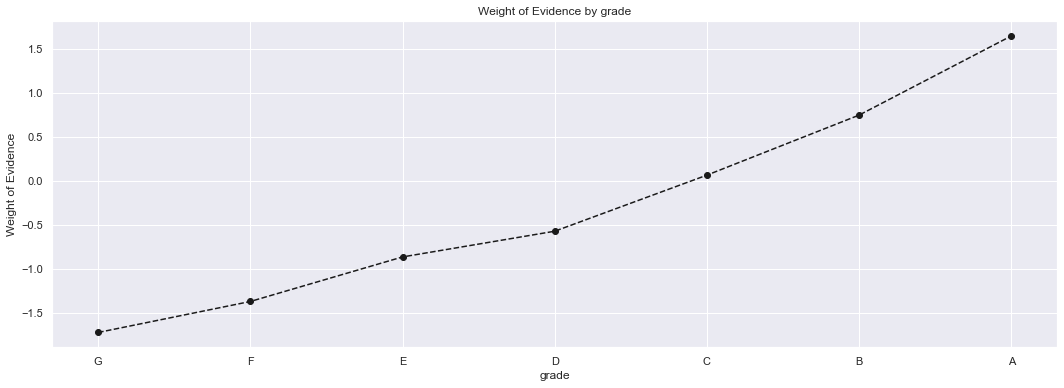

In [47]:
plot_woe(df_temp)

###### home ownership

In [48]:
# compute WoE for home_ownership
df_temp = woe_discrete(sample_input_df, 'home_ownership', sample_target_df)
df_temp
# COMMENT: 
# Other and None has the most bad (=worst good) (=lower WoE = most negative WoE) but their number of observation is tiny --> hence can combine with the next most bad category: Rent.
# Any has only 1 observation --> hence can also combine with Other, None and Rent without affecting the WoE.
# Own cannot be combined with Rent because their WoE are quite different and opposite sign. 
# Mortgage cannot be combine with other category because their number of observation is large.

,home_ownership,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,RENT,167644,0.976933,0.398115,163777.0,3867.0,0.396321,0.492549,-0.217368,NaN,NaN,inf
1,OWN,45766,0.980750,0.108684,44885.0,881.0,0.108616,0.112215,-0.032594,0.003817,0.184775,inf
2,MORTGAGE,207682,0.985059,0.493196,204579.0,3103.0,0.495057,0.395236,0.225190,0.004309,0.257784,inf
3,ANY,2,1.000000,0.000005,2.0,0.0,0.000005,0.000000,inf,0.014941,inf,inf


In [49]:
sample_input_df['home_ownership'].unique()
# NOTE: The home ownership subcategories has changed. No longer there is Other & None. Either because the population has changed or because the data is much cleaner --> this can be ignored --> simply remove Other and None sub categories in the below cell. 

array(['MORTGAGE', 'RENT', 'OWN', 'ANY'], dtype=object)

In [50]:
sample_input_df['home_ownership:Rent_Other_None_Any'] = sum([
    sample_input_df['home_ownership:RENT'],
    # sample_input_df['home_ownership:OTHER'],
    # sample_input_df['home_ownership:NONE'],
    sample_input_df['home_ownership:ANY']
])   # combine home_ownership: Other + None + Rent + Any = 1 if belongs to any of the 4 categories, 0 otherwise

###### adress state

In [51]:
sample_input_df['addr_state'].unique()

array(['DC', 'IN', 'KS', 'IL', 'OR', 'VA', 'PA', 'GA', 'TN', 'OH', 'NY',
       'FL', 'NJ', 'RI', 'NC', 'AL', 'TX', 'SC', 'MD', 'WA', 'MO', 'MN',
       'NH', 'VT', 'AZ', 'MI', 'MA', 'CA', 'LA', 'DE', 'NM', 'CO', 'WI',
       'SD', 'CT', 'NE', 'HI', 'AR', 'MT', 'WV', 'WY', 'OK', 'NV', 'KY',
       'MS', 'ME', 'UT', 'ND', 'AK'], dtype=object)

In [52]:
# compute WoE for customer's address state
df_temp = woe_discrete(sample_input_df, 'addr_state',sample_target_df)
df_temp

,addr_state,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,NV,5924,0.969953,0.014068,5746.0,178.0,0.013905,0.022672,-0.488919,NaN,NaN,inf
1,SD,835,0.970060,0.001983,810.0,25.0,0.001960,0.003184,-0.485236,0.000107,0.003683,inf
2,HI,2083,0.973596,0.004947,2028.0,55.0,0.004908,0.007005,-0.355923,0.003536,0.129314,inf
3,OK,3968,0.976310,0.009423,3874.0,94.0,0.009375,0.011973,-0.244647,0.002715,0.111276,inf
4,AK,954,0.977987,0.002266,933.0,21.0,0.002258,0.002675,-0.169512,0.001677,0.075135,inf
5,NY,33844,0.978253,0.080372,33108.0,736.0,0.080118,0.093746,-0.157095,0.000266,0.012417,inf
6,AL,5347,0.978306,0.012698,5231.0,116.0,0.012658,0.014775,-0.154627,0.000052,0.002467,inf
7,UT,2836,0.978491,0.006735,2775.0,61.0,0.006715,0.007770,-0.145863,0.000185,0.008765,inf
8,WY,900,0.978889,0.002137,881.0,19.0,0.002132,0.002420,-0.126776,0.000398,0.019086,inf
9,FL,29298,0.979111,0.069576,28686.0,612.0,0.069417,0.077952,-0.115963,0.000222,0.010814,inf


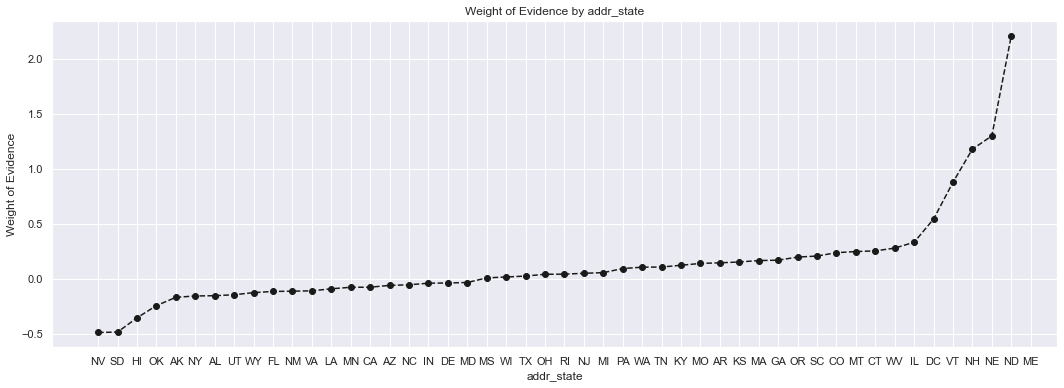

In [53]:
plot_woe(df_temp)
#NOTE:
# NE and IA are much lower than other states
# ME and ID have infinite WoE value because there is no bad observation

In [54]:
# if there is a column name addr_state:ND in the sample input df then we pass. Else create such column with value of 0
if ['addr_state:ND'] in sample_input_df.columns.values:
    pass
else:
    sample_input_df['addr_state:ND'] = 0
# risk manager with the conservative view would put all category with no information to the highest risk category (= worst category)

In [55]:
# if there is a column name addr_state:ID in the sample input df then we pass. Else create such column with value of 0
if ['addr_state:ID'] in sample_input_df.columns.values:
    pass
else:
    sample_input_df['addr_state:ID'] = 0

In [56]:
# if there is a column name addr_state:IA in the sample input df then we pass. Else create such column with value of 0
if ['addr_state:IA'] in sample_input_df.columns.values:
    pass
else:
    sample_input_df['addr_state:IA'] = 0

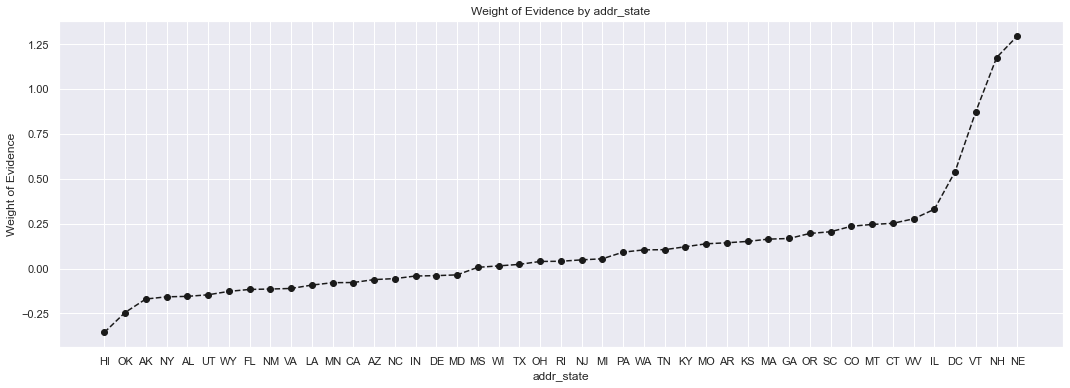

In [57]:
# plot other states apart from the bottom 2 and the first 2 WoE
plot_woe(df_temp.iloc[2:-2, : ])    # from the 3th row to the 3rd lastest row, all columns

# using the below graph and the number of observation in df_temp df to group the categories:
# NV are the lowest in this chart, and relatively low number of obs. FL HI AL have similar WoE. Together with missing ND above, and the worst 2 WoE above NE IA --> grouped together
# top 6 highest WoE can be group together also because of low number of observation: WV NH WY DC ME ID

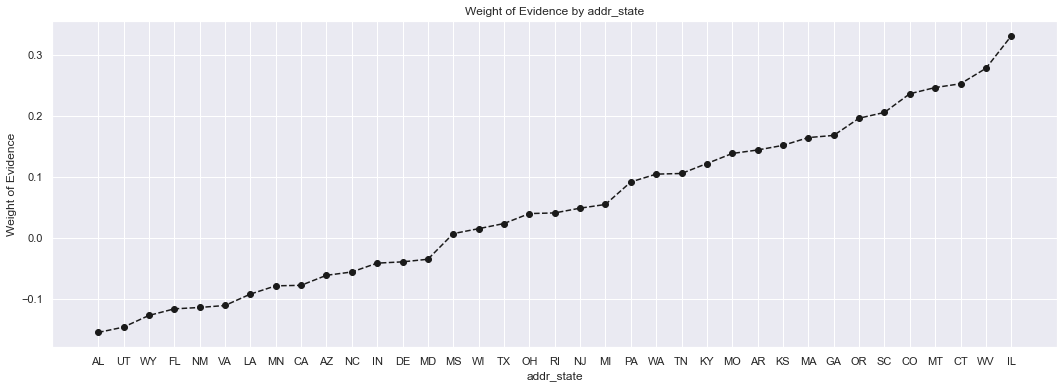

In [58]:
# remaining states apart from those have been categorised above
plot_woe(df_temp.iloc[6:-6, : ]) 

# again, using the below graph and the number of observation in df_temp df to group the categories:
# NM to CA have similar WoE. However, NY and CA have large number of observations --> they are in their own groups. The rest can be grouped together, seperated by NY and CA
# --> NM VA
# NY
# OK TN MO 
# LA 
# MD NC CA
# UT and NJ have similar WoE --> grouped. Since none of them have significant number of observation. 
# likewise for AR MI PA OH MN 
# likewise for RI MA DE SD IN
# likewise for GA WA OR
# WI and MT do not have the similar WoE but low observations --> grouped
# TX have higher observations --> seperate group
# IL CT similar WoE --> grouped 
# KS - MS have high WoE but low observation --> grouped 

In [59]:
# create categories where more than 1 states are combined
sample_input_df['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([
    sample_input_df['addr_state:ND'],   # missing state
    sample_input_df['addr_state:NE'],   # 2 lowest WoE
    sample_input_df['addr_state:IA'],
    sample_input_df['addr_state:NV'],   
    sample_input_df['addr_state:FL'],
    sample_input_df['addr_state:HI'],
    sample_input_df['addr_state:AL']
])
sample_input_df['addr_state:WV_NH_WY_DC_ME_ID'] = sum([
    sample_input_df['addr_state:WV'],
    sample_input_df['addr_state:NH'],
    sample_input_df['addr_state:WY'],
    sample_input_df['addr_state:DC'],
    sample_input_df['addr_state:ME'],
    sample_input_df['addr_state:ID']
])  #top 6 highest WoE, with low number of observations
sample_input_df['addr_state:NM_VA'] = sum([
    sample_input_df['addr_state:NM'], 
    sample_input_df['addr_state:VA']
])
sample_input_df['addr_state:OK_TN_MO_LA_MD_NC'] = sum([
    sample_input_df['addr_state:OK'], 
    sample_input_df['addr_state:TN'],
    sample_input_df['addr_state:MO'], 
    sample_input_df['addr_state:LA'],
    sample_input_df['addr_state:MD'], 
    sample_input_df['addr_state:NC']
])
sample_input_df['addr_state:UT_KY_AZ_NJ'] = sum([
    sample_input_df['addr_state:UT'], 
    sample_input_df['addr_state:KY'],
    sample_input_df['addr_state:AZ'], 
    sample_input_df['addr_state:NJ']
])
sample_input_df['addr_state:AR_MI_PA_OH_MN'] = sum([
    sample_input_df['addr_state:AR'], 
    sample_input_df['addr_state:MI'],
    sample_input_df['addr_state:PA'], 
    sample_input_df['addr_state:OH'],
    sample_input_df['addr_state:MN']
])
sample_input_df['addr_state:RI_MA_DE_SD_IN'] = sum([
    sample_input_df['addr_state:RI'], 
    sample_input_df['addr_state:MA'],
    sample_input_df['addr_state:DE'], 
    sample_input_df['addr_state:SD'],
    sample_input_df['addr_state:IN']
])
sample_input_df['addr_state:GA_WA_OR'] = sum([
    sample_input_df['addr_state:GA'], 
    sample_input_df['addr_state:WA'],
    sample_input_df['addr_state:OR']
])
sample_input_df['addr_state:WI_MT'] = sum([
    sample_input_df['addr_state:WI'], 
    sample_input_df['addr_state:MT']
])
sample_input_df['addr_state:IL_CT'] = sum([
    sample_input_df['addr_state:IL'], 
    sample_input_df['addr_state:CT']
])
sample_input_df['addr_state:KS_SC_CO_VT_AK_MS'] = sum([
    sample_input_df['addr_state:KS'], 
    sample_input_df['addr_state:SC'],
    sample_input_df['addr_state:CO'], 
    sample_input_df['addr_state:VT'],
    sample_input_df['addr_state:AK'], 
    sample_input_df['addr_state:MS']
])

###### verification status

In [60]:
df_temp = woe_discrete(sample_input_df, 'verification_status', sample_target_df)
df_temp

,verification_status,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,Verified,123016,0.976532,0.292134,120129.0,2887.0,0.290698,0.367724,-0.235047,NaN,NaN,0.046808
1,Source Verified,179565,0.981110,0.426425,176173.0,3392.0,0.426318,0.432047,-0.013348,0.004578,0.221698,0.046808
2,Not Verified,118513,0.986736,0.281441,116941.0,1572.0,0.282984,0.200229,0.345926,0.005626,0.359274,0.046808


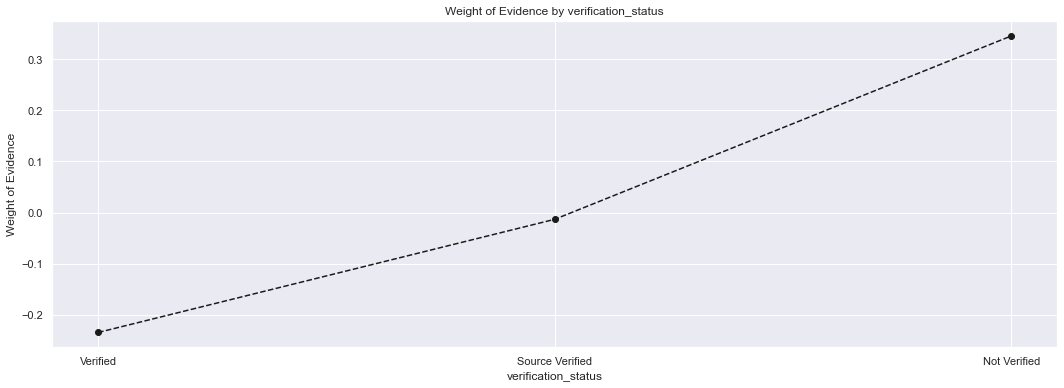

In [61]:
plot_woe(df_temp)

###### purpose

In [62]:
df_temp = woe_discrete(sample_input_df, 'purpose', sample_target_df)
df_temp

,purpose,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,wedding,4,0.750000,0.000009,3.0,1.0,0.000007,0.000127,-2.864783,NaN,NaN,inf
1,renewable_energy,224,0.955357,0.000532,214.0,10.0,0.000518,0.001274,-0.900004,0.205357,1.964779,inf
2,small_business,3364,0.958680,0.007989,3225.0,139.0,0.007804,0.017705,-0.819181,0.003323,0.080823,inf
3,moving,2420,0.965289,0.005747,2336.0,84.0,0.005653,0.010699,-0.638016,0.006609,0.181164,inf
4,house,1438,0.967316,0.003415,1391.0,47.0,0.003366,0.005986,-0.575764,0.002026,0.062252,inf
5,medical,3938,0.970797,0.009352,3823.0,115.0,0.009251,0.014648,-0.459536,0.003482,0.116228,inf
6,major_purchase,7449,0.975970,0.017690,7270.0,179.0,0.017593,0.022800,-0.259269,0.005173,0.200267,inf
7,other,19204,0.976672,0.045605,18756.0,448.0,0.045387,0.057063,-0.228919,0.000702,0.030350,inf
8,vacation,2249,0.977768,0.005341,2199.0,50.0,0.005321,0.006369,-0.179660,0.001096,0.049259,inf
9,debt_consolidation,250020,0.979878,0.593739,244989.0,5031.0,0.592845,0.640810,-0.077800,0.002110,0.101860,inf


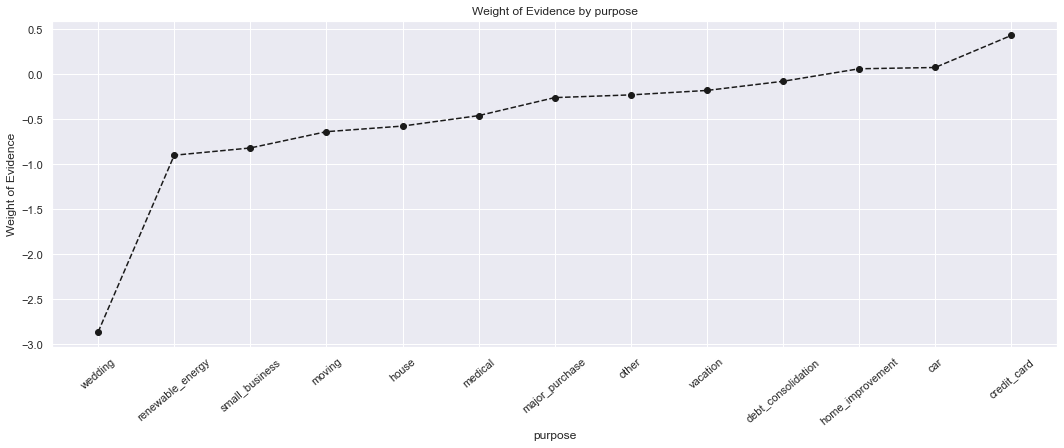

In [63]:
plot_woe(df_temp, 40)

In [64]:
# group couple of categories together 
sample_input_df['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([
    sample_input_df['purpose:educational'], 
    sample_input_df['purpose:small_business'],
    sample_input_df['purpose:wedding'], 
    sample_input_df['purpose:renewable_energy'],
    sample_input_df['purpose:moving'], 
    sample_input_df['purpose:house']
])
sample_input_df['purpose:oth__med__vacation'] = sum([
    sample_input_df['purpose:other'], 
    sample_input_df['purpose:medical'],
    sample_input_df['purpose:vacation']
])
sample_input_df['purpose:debt_consolidation'] = sample_input_df['purpose:debt_consolidation']   # own category
sample_input_df['purpose:major_purch__car__home_impr'] = sum([
    sample_input_df['purpose:major_purchase'], 
    sample_input_df['purpose:car'],
    sample_input_df['purpose:home_improvement']
])
sample_input_df['purpose:credit_card'] = sample_input_df['purpose:credit_card']   # own category

###### initial_list_status

In [65]:
df_temp = woe_discrete(sample_input_df, 'initial_list_status', sample_target_df)
df_temp

,initial_list_status,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,f,153843,0.972550,0.365341,149620.0,4223.0,0.362063,0.537893,-0.395842,NaN,NaN,0.126296
1,w,267251,0.986425,0.634659,263623.0,3628.0,0.637937,0.462107,0.322444,0.013875,0.718286,0.126296


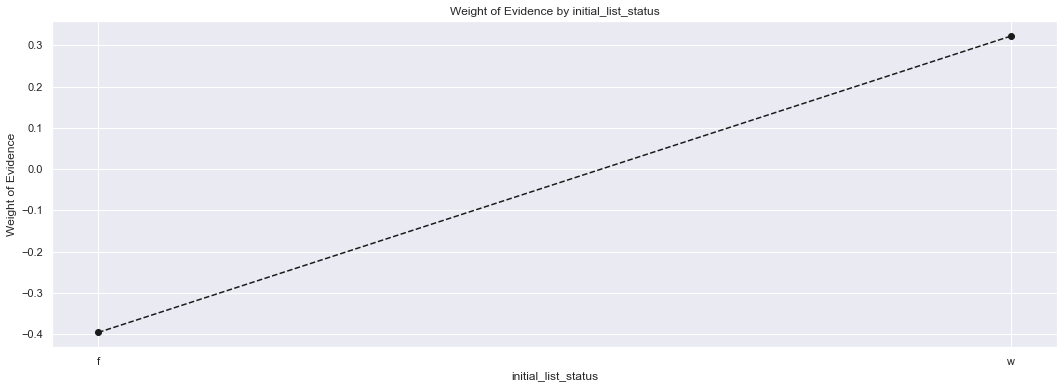

In [66]:
plot_woe(df_temp)

##### continuous variable

###### function to compute WoE, IV for any continuous variable

In [67]:
# use similar function as the WoE discrete. But not sort by WoE. Rather sort by original variable values
def woe_continuous(df, continuous_variable_name, good_bad_df):
    df = pd.concat(
        [df[continuous_variable_name], good_bad_df],
        axis=1
    )       #concat independent variable and dependent variable
    df = pd.concat(
        [
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].count(),
            df.groupby(
                df.columns.values[0],
                as_index=False
            )[df.columns.values[1]].mean()
        ],
        axis=1 
    )   #compute count of each category in the dependent variable and % of good in each category
    df = df.iloc[:, [0,1,3]]  #only retain the 1st, 2nd and 4th column
    df.columns = [df.columns.values[0], 'n_obs', 'prcnt_good']    #rename columns
    df['prcnt_n_obs'] = df['n_obs']/df['n_obs'].sum()    #proportion of each category = number of observation each category/total number of observations
    
    df['n_good'] = df['n_obs'] * df['prcnt_good']        #number of good in each category
    df['n_bad'] = df['n_obs'] * (1 - df['prcnt_good'])        #number of bad in each category
    
    df['prcnt_n_good'] = df['n_good']/df['n_good'].sum()     #proportion of number of good of each category, out of total number of goods = proportion of the column sum
    df['prcnt_n_bad'] = df['n_bad']/df['n_bad'].sum()        #likewise for the proportion of number of bad
    
    df['WoE'] = np.log(df['prcnt_n_good']/df['prcnt_n_bad']) #compute Weight of Evidence
    
    #df = df.sort_values(['WoE'])  #sort by WoE
    #df = df.reset_index(drop=True)    #reset index, drop old index
    
    df['diff_prcnt_good'] = df['prcnt_good'].diff().abs()     #compute row difference in column percentage good. Take absolute to see the increase from 1 class to the next
    df['diff_WoE'] = df['WoE'].diff().abs()     #compute row difference in column WoE
    
    df['IV'] = (df['prcnt_n_good'] - df['prcnt_n_bad']) * df['WoE'] #for each category (= each row), compute the difference between % good and % bad then multiply by WoE of the category
    df['IV'] = df['IV'].sum()		#sum all IV value across all categories

    return df

###### term int

In [68]:
# compute and visualise WoE for continuous variable Term_int
df_temp = woe_continuous(sample_input_df, 'term_int', sample_target_df)
df_temp
# term=60 is riskier than term=36

,term_int,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,36,283172,0.983533,0.672467,278509.0,4663.0,0.673959,0.593937,0.126396,NaN,NaN,0.027678
1,60,137922,0.976885,0.327533,134734.0,3188.0,0.326041,0.406063,-0.219486,0.006647,0.345883,0.027678


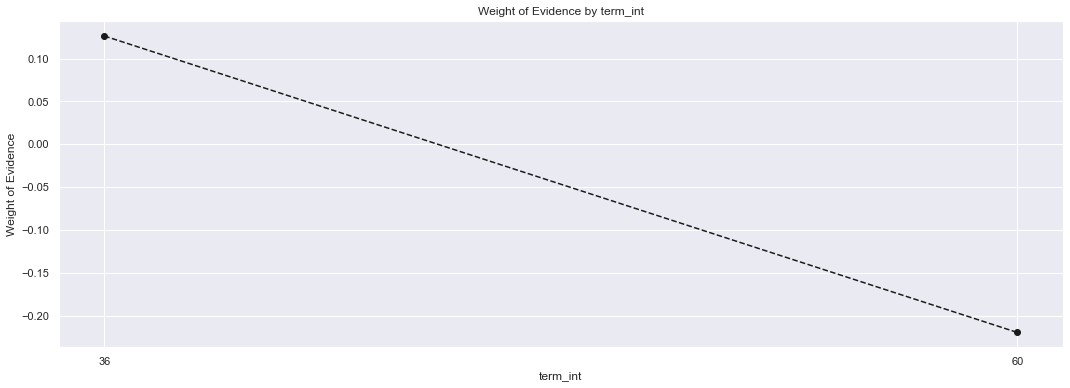

In [69]:
plot_woe(df_temp)

In [70]:
#create dummy variables from continuous variable term_int
sample_input_df['term:36'] = np.where(
    sample_input_df['term_int']==36,
    1,
    0
)   # set value for the dummy variable term:36 = 1 when term_int=36. = 0 otherwise
sample_input_df['term:60'] = np.where(sample_input_df['term_int']==60,1,0)

In [71]:
# compute and visualise WoE for continuous variable emp_length
df_temp = woe_continuous(sample_input_df, 'emp_length_int', sample_target_df)
df_temp

,emp_length_int,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,58157,0.977733,0.138109,56862.0,1295.0,0.137599,0.164947,-0.181278,NaN,NaN,0.019134
1,1.0,27473,0.977687,0.065242,26860.0,613.0,0.064998,0.078079,-0.183366,0.000046,0.002088,0.019134
2,2.0,37497,0.980932,0.089047,36782.0,715.0,0.089008,0.091071,-0.022914,0.003245,0.160453,0.019134
3,3.0,33430,0.980975,0.079388,32794.0,636.0,0.079358,0.081009,-0.020593,0.000043,0.002321,0.019134
4,4.0,24506,0.979678,0.058196,24008.0,498.0,0.058097,0.063431,-0.087853,0.001297,0.067260,0.019134
5,5.0,24930,0.980866,0.059203,24453.0,477.0,0.059173,0.060757,-0.026403,0.001188,0.061449,0.019134
6,6.0,16838,0.978976,0.039986,16484.0,354.0,0.039889,0.045090,-0.122546,0.001890,0.096143,0.019134
7,7.0,18414,0.979201,0.043729,18031.0,383.0,0.043633,0.048784,-0.111582,0.000224,0.010964,0.019134
8,8.0,21560,0.983905,0.051200,21213.0,347.0,0.051333,0.044198,0.149650,0.004705,0.261232,0.019134
9,9.0,16769,0.982289,0.039822,16472.0,297.0,0.039860,0.037830,0.052290,0.001617,0.097360,0.019134


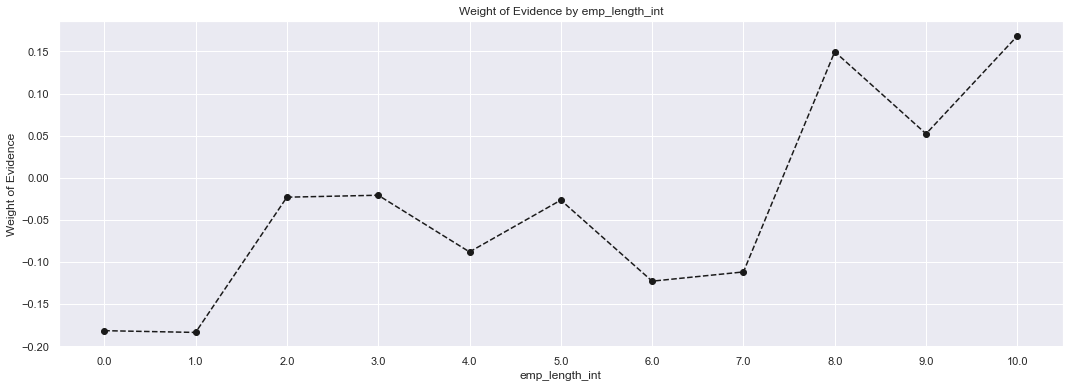

In [72]:
plot_woe(df_temp)

###### employment length

In [73]:
#create dummy variables from continuous variable term_int
sample_input_df['emp_length:0'] = np.where(sample_input_df['emp_length_int'].isin([0]),1,0)
sample_input_df['emp_length:1'] = np.where(sample_input_df['emp_length_int'].isin([1]),1,0)
sample_input_df['emp_length:2-4'] = np.where(sample_input_df['emp_length_int'].isin(range(2,5)),1,0)    #coarse classing. Range value from 2 to 4, exclude 5
sample_input_df['emp_length:5-6'] = np.where(sample_input_df['emp_length_int'].isin(range(5,7)),1,0)
sample_input_df['emp_length:7-9'] = np.where(sample_input_df['emp_length_int'].isin(range(7,10)),1,0)
sample_input_df['emp_length:10'] = np.where(sample_input_df['emp_length_int'].isin([10]),1,0)

###### months since issue date

In [74]:
# inspect continuous variable mnths_since_issue_d
sample_input_df['mths_since_issue_d']

id
68444620    24.0
68547583    24.0
67849662    24.0
68506885    24.0
68341763    24.0
            ... 
36371250    35.0
36441262    35.0
36271333    35.0
36490806    35.0
36271262    35.0
Name: mths_since_issue_d, Length: 421094, dtype: float64

In [75]:
sample_input_df['mths_since_issue_d'].unique()  
# there are 100 unique values --> we would like to trim it down

array([24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.])

In [76]:
# use panda's cut function to trim the variable down
sample_input_df['mths_since_issue_d_factor'] = pd.cut(sample_input_df['mths_since_issue_d'], 50)     #factor = common used term for categorical variable
sample_input_df['mths_since_issue_d_factor'] 

id
68444620    (23.989, 24.22]
68547583    (23.989, 24.22]
67849662    (23.989, 24.22]
68506885    (23.989, 24.22]
68341763    (23.989, 24.22]
                 ...       
36371250      (34.78, 35.0]
36441262      (34.78, 35.0]
36271333      (34.78, 35.0]
36490806      (34.78, 35.0]
36271262      (34.78, 35.0]
Name: mths_since_issue_d_factor, Length: 421094, dtype: category
Categories (50, interval[float64]): [(23.989, 24.22] < (24.22, 24.44] < (24.44, 24.66] < (24.66, 24.88] ... (34.12, 34.34] < (34.34, 34.56] < (34.56, 34.78] < (34.78, 35.0]]

In [77]:
# compute and visualise WoE for continuous variable mths_since_issue_d_factor
df_temp = woe_continuous(sample_input_df, 'mths_since_issue_d_factor', sample_target_df)
df_temp

,mths_since_issue_d_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(23.989, 24.22]",44342,1.000000,0.105302,44342.0,0.0,0.107302,0.000000,inf,NaN,NaN,inf
1,"(24.22, 24.44]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(24.44, 24.66]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(24.66, 24.88]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(24.88, 25.1]",37530,0.998082,0.089125,37458.0,72.0,0.090644,0.009171,2.290915,NaN,NaN,inf
5,"(25.1, 25.32]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(25.32, 25.54]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(25.54, 25.76]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(25.76, 25.98]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(25.98, 26.2]",48631,0.997327,0.115487,48501.0,130.0,0.117367,0.016558,1.958410,NaN,NaN,inf


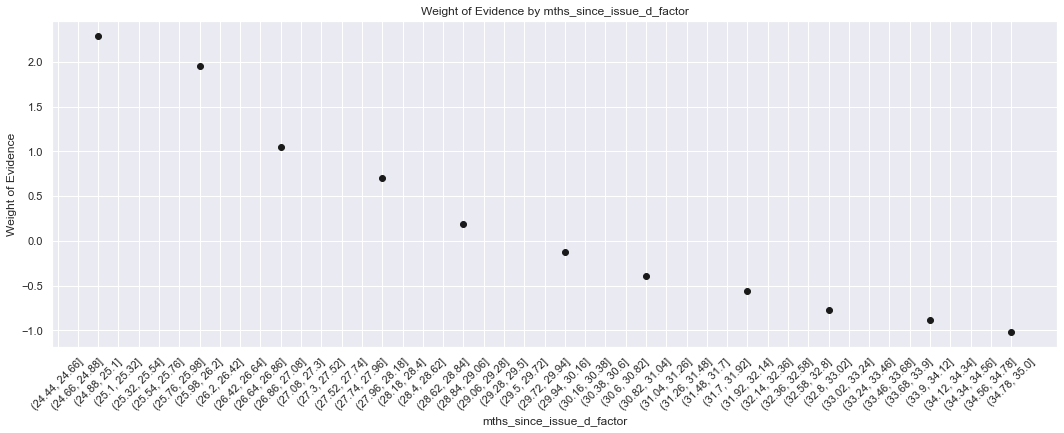

In [78]:
plot_woe(df_temp, 45)

In [79]:
sample_input_df['mths_since_issue_d:<38'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(38)), 1, 0)
sample_input_df['mths_since_issue_d:38-39'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(38, 40)), 1, 0)
sample_input_df['mths_since_issue_d:40-41'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(40, 42)), 1, 0)
sample_input_df['mths_since_issue_d:42-48'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(42, 49)), 1, 0)
sample_input_df['mths_since_issue_d:49-52'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(49, 53)), 1, 0)
sample_input_df['mths_since_issue_d:53-64'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(53, 65)), 1, 0)
sample_input_df['mths_since_issue_d:65-84'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(65, 85)), 1, 0)
sample_input_df['mths_since_issue_d:>84'] = np.where(sample_input_df['mths_since_issue_d'].isin(range(85, int(sample_input_df['mths_since_issue_d'].max()))), 1, 0)

###### interest rate

In [80]:
# do the same for continuous variable int_rate. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['int_rate_factor'] = pd.cut(sample_input_df['int_rate'], 50)
df_temp = woe_continuous(sample_input_df, 'int_rate_factor', sample_target_df)
df_temp

,int_rate_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(5.296, 5.793]",9651,0.999689,0.022919,9648.0,3.0,0.023347,0.000382,4.112499,NaN,NaN,inf
1,"(5.793, 6.267]",10214,0.997259,0.024256,10186.0,28.0,0.024649,0.003566,1.933170,0.002430,2.179329,inf
2,"(6.267, 6.74]",6530,0.994793,0.015507,6496.0,34.0,0.015720,0.004331,1.289186,0.002465,0.643984,inf
3,"(6.74, 7.214]",12488,0.995275,0.029656,12429.0,59.0,0.030077,0.007515,1.386855,0.000482,0.097669,inf
4,"(7.214, 7.687]",11416,0.997985,0.027110,11393.0,23.0,0.027570,0.002930,2.241865,0.002710,0.855010,inf
5,"(7.687, 8.16]",20636,0.995687,0.049006,20547.0,89.0,0.049721,0.011336,1.478439,0.002298,0.763426,inf
6,"(8.16, 8.634]",22498,0.994133,0.053428,22366.0,132.0,0.054123,0.016813,1.169100,0.001554,0.309339,inf
7,"(8.634, 9.107]",2020,0.979703,0.004797,1979.0,41.0,0.004789,0.005222,-0.086620,0.014430,1.255720,inf
8,"(9.107, 9.581]",22171,0.992783,0.052651,22011.0,160.0,0.053264,0.020380,0.960729,0.013080,1.047349,inf
9,"(9.581, 10.054]",22364,0.993829,0.053109,22226.0,138.0,0.053784,0.017577,1.118369,0.001046,0.157641,inf


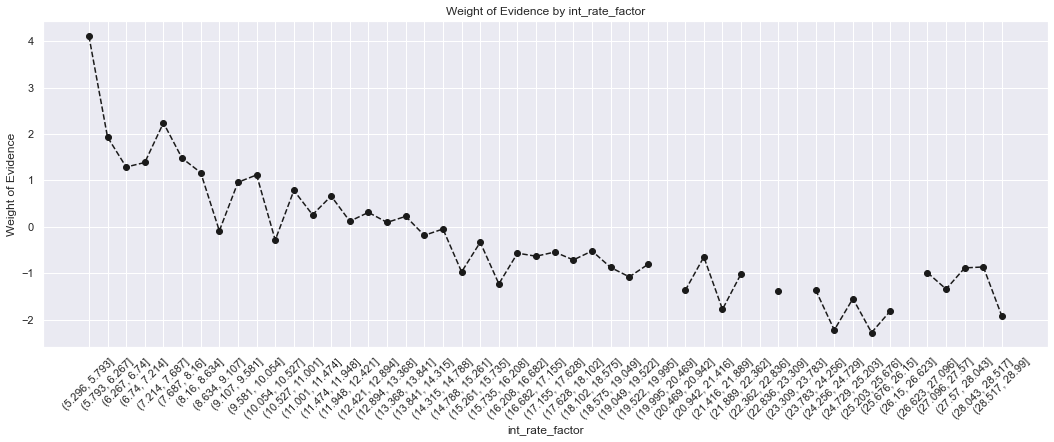

In [81]:
plot_woe(df_temp, 45)

In [82]:
# create coarse classing dummy variables
sample_input_df['int_rate:<9.548'] = np.where((sample_input_df['int_rate'] <= 9.548), 1, 0) #all WoE that are very volatile like those less than 9.548 indicates that they do not have sufficient evidence --> can be grouped together
sample_input_df['int_rate:9.548-12.025'] = np.where((sample_input_df['int_rate'] > 9.548) & (sample_input_df['int_rate'] <= 12.025), 1, 0)
sample_input_df['int_rate:12.025-15.74'] = np.where((sample_input_df['int_rate'] > 12.025) & (sample_input_df['int_rate'] <= 15.74), 1, 0)
sample_input_df['int_rate:15.74-20.281'] = np.where((sample_input_df['int_rate'] > 15.74) & (sample_input_df['int_rate'] <= 20.281), 1, 0)
sample_input_df['int_rate:>20.281'] = np.where((sample_input_df['int_rate'] > 20.281), 1, 0)

###### funded amount

In [83]:
# do the same for continuous variable funded_amt. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['funded_amnt_factor'] = pd.cut(sample_input_df['funded_amnt'], 50)
df_temp = woe_continuous(sample_input_df, 'funded_amnt_factor', sample_target_df)
df_temp

,funded_amnt_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(966.0, 1680.0]",3391,0.982306,0.008053,3331.0,60.0,0.008061,0.007642,0.053288,NaN,NaN,0.027107
1,"(1680.0, 2360.0]",3751,0.981338,0.008908,3681.0,70.0,0.008908,0.008916,-0.000950,0.000968,0.054239,0.027107
2,"(2360.0, 3040.0]",8134,0.981190,0.019316,7981.0,153.0,0.019313,0.019488,-0.009014,0.000148,0.008063,0.027107
3,"(3040.0, 3720.0]",5133,0.983246,0.012190,5047.0,86.0,0.012213,0.010954,0.108807,0.002056,0.117821,0.027107
4,"(3720.0, 4400.0]",7315,0.980041,0.017371,7169.0,146.0,0.017348,0.018596,-0.069480,0.003205,0.178287,0.027107
5,"(4400.0, 5080.0]",18150,0.982479,0.043102,17832.0,318.0,0.043151,0.040504,0.063304,0.002438,0.132784,0.027107
6,"(5080.0, 5760.0]",5617,0.984867,0.013339,5532.0,85.0,0.013387,0.010827,0.212259,0.002388,0.148955,0.027107
7,"(5760.0, 6440.0]",16224,0.982618,0.038528,15942.0,282.0,0.038578,0.035919,0.071410,0.002249,0.140848,0.027107
8,"(6440.0, 7120.0]",10565,0.982489,0.025089,10380.0,185.0,0.025118,0.023564,0.063885,0.000129,0.007525,0.027107
9,"(7120.0, 7800.0]",8423,0.980173,0.020003,8256.0,167.0,0.019979,0.021271,-0.062693,0.002316,0.126579,0.027107


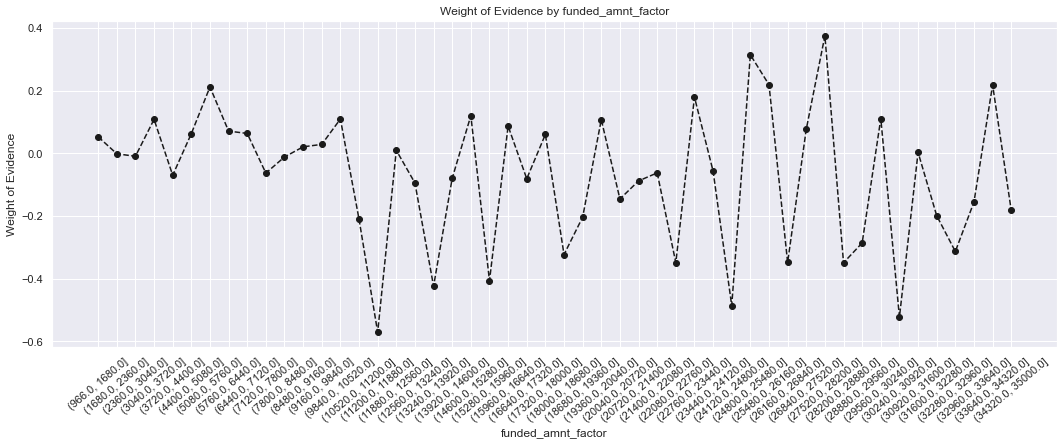

In [84]:
plot_woe(df_temp, 40)
#NOTE: WoE is horizontal for most values --> there seems no evidence of WoE --> not use the variable for the model

###### months since earliest credit line

In [85]:
# do the same for continuous variable mths_since_earliest_cr_line. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['mths_since_earliest_cr_line'].unique()

array([334., 197.,  77., 228., 208., 193., 192., 172., 362., 296., 422.,
       234., 187., 183., 195., 153., 205., 111., 277., 403., 196., 203.,
       230., 158., 240., 318., 258., 198., 100., 319., 244., 384., 190.,
       346., 210., 191., 166., 135., 330., 307., 201., 180., 284., 131.,
       262., 186.,  74., 188., 227., 239., 152., 123., 134., 150., 155.,
       291., 145., 364., 217., 162., 138., 332., 270., 181., 376., 176.,
        83.,  97., 112., 272., 283., 254., 200., 161., 159., 279.,  70.,
       216., 246., 218., 207., 115., 263., 171., 226., 160., 146., 169.,
       189., 289., 360., 126., 199., 211., 139., 128., 358., 163., 182.,
       167., 344., 411., 339., 118., 140., 320., 220., 290., 164.,  67.,
       202., 175., 361., 343., 105., 119., 438., 170., 480., 214., 414.,
       261., 184., 235., 483., 327., 520., 391., 251., 274.,  76., 204.,
       223., 225., 213., 356., 313., 253., 232., 308., 156., 257., 385.,
       458.,  96., 293., 110., 249., 416., 173., 20

In [86]:
sample_input_df['mths_since_earliest_cr_line_factor'] = pd.cut(sample_input_df['mths_since_earliest_cr_line'], 50)
df_temp = woe_continuous(sample_input_df, 'mths_since_earliest_cr_line_factor', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,mths_since_earliest_cr_line_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(60.174, 77.52]",4727,0.977787,0.011226,4622.0,105.0,0.011185,0.013374,-0.178772,NaN,NaN,inf
1,"(77.52, 94.04]",7570,0.973052,0.017977,7366.0,204.0,0.017825,0.025984,-0.376885,0.004736,0.198112,inf
2,"(94.04, 110.56]",7983,0.971439,0.018958,7755.0,228.0,0.018766,0.029041,-0.436647,0.001612,0.059763,inf
3,"(110.56, 127.08]",16247,0.976980,0.038583,15873.0,374.0,0.038411,0.047637,-0.215276,0.005541,0.221372,inf
4,"(127.08, 143.6]",20569,0.975011,0.048847,20055.0,514.0,0.048531,0.065469,-0.299384,0.001969,0.084109,inf
5,"(143.6, 160.12]",33434,0.978585,0.079398,32718.0,716.0,0.079174,0.091199,-0.141394,0.003574,0.157990,inf
6,"(160.12, 176.64]",35962,0.979423,0.085401,35222.0,740.0,0.085233,0.094256,-0.100619,0.000838,0.040775,inf
7,"(176.64, 193.16]",39155,0.979339,0.092984,38346.0,809.0,0.092793,0.103044,-0.104788,0.000084,0.004169,inf
8,"(193.16, 209.68]",39248,0.981579,0.093205,38525.0,723.0,0.093226,0.092090,0.012259,0.002240,0.117047,inf
9,"(209.68, 226.2]",34783,0.982261,0.082602,34166.0,617.0,0.082678,0.078589,0.050722,0.000683,0.038464,inf


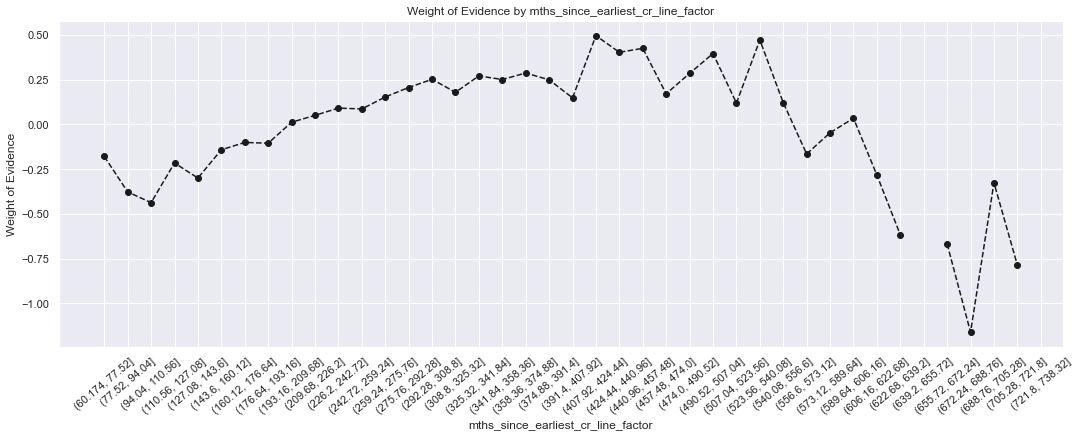

In [87]:
plot_woe(df_temp, 40)

In [88]:
sample_input_df['mths_since_earliest_cr_line:<140'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:141-164'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:165-247'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:248-270'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:271-352'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
sample_input_df['mths_since_earliest_cr_line:>352'] = np.where(sample_input_df['mths_since_earliest_cr_line'].isin(range(353, int(sample_input_df['mths_since_earliest_cr_line'].max()))), 1, 0)

###### delinquency last 2 years

In [89]:
# do the same for continuous variable delinq_2yrs. 
sample_input_df['delinq_2yrs'].unique()

array([ 0.,  2.,  1.,  3.,  4.,  6.,  5., 15.,  7.,  9., 10.,  8., 11.,
       13., 14., 12., 30., 18., 16., 17., 26., 20., 19., 22., 27., 39.])

In [90]:
df_temp = woe_continuous(sample_input_df, 'delinq_2yrs', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,delinq_2yrs,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,334007,0.981812,0.793189,327932.0,6075.0,0.793557,0.773787,0.025229,NaN,NaN,inf
1,1.0,57000,0.980246,0.135362,55874.0,1126.0,0.135209,0.143421,-0.058967,0.001566,0.084197,inf
2,2.0,17241,0.979120,0.040943,16881.0,360.0,0.040850,0.045854,-0.115555,0.001126,0.056588,inf
3,3.0,6293,0.976800,0.014944,6147.0,146.0,0.014875,0.018596,-0.223282,0.002320,0.107727,inf
4,4.0,2949,0.976263,0.007003,2879.0,70.0,0.006967,0.008916,-0.246692,0.000536,0.023410,inf
5,5.0,1475,0.978305,0.003503,1443.0,32.0,0.003492,0.004076,-0.154651,0.002042,0.092041,inf
6,6.0,842,0.980998,0.002000,826.0,16.0,0.001999,0.002038,-0.019389,0.002693,0.135262,inf
7,7.0,438,0.984018,0.001040,431.0,7.0,0.001043,0.000892,0.156803,0.003021,0.176192,inf
8,8.0,284,0.982394,0.000674,279.0,5.0,0.000675,0.000637,0.058379,0.001624,0.098424,inf
9,9.0,173,0.976879,0.000411,169.0,4.0,0.000409,0.000509,-0.219791,0.005516,0.278170,inf


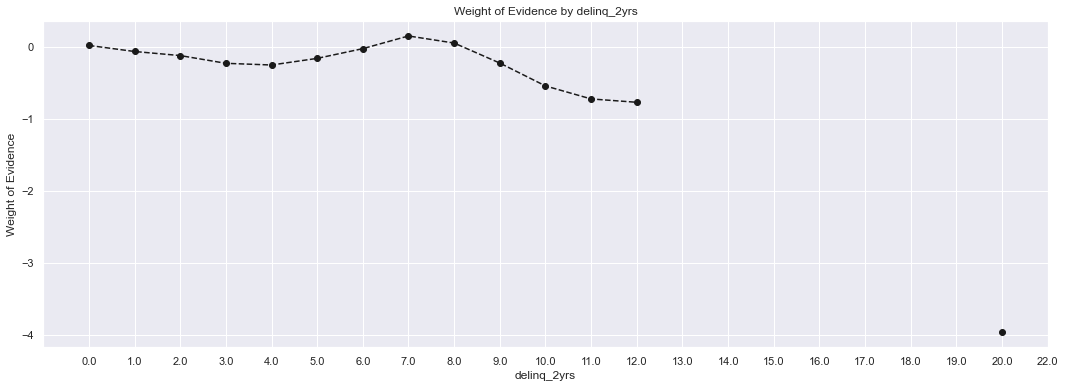

In [91]:
plot_woe(df_temp)

In [92]:
sample_input_df['delinq_2yrs:0'] = np.where((sample_input_df['delinq_2yrs'] == 0), 1, 0)
sample_input_df['delinq_2yrs:1-3'] = np.where((sample_input_df['delinq_2yrs'] >= 1) & (sample_input_df['delinq_2yrs'] <= 3), 1, 0)
sample_input_df['delinq_2yrs:>=4'] = np.where((sample_input_df['delinq_2yrs'] >= 9), 1, 0)

In [93]:
# do the same for continuous variable inq_last_6mths.
df_temp = woe_continuous(sample_input_df, 'inq_last_6mths', sample_target_df)
df_temp

,inq_last_6mths,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,256407,0.984813,0.608907,252513.0,3894.0,0.611052,0.495988,0.208631,NaN,NaN,0.06837
1,1.0,111346,0.978571,0.264421,108960.0,2386.0,0.263671,0.303910,-0.142032,0.006242,0.350663,0.06837
2,2.0,36292,0.973438,0.086185,35328.0,964.0,0.085490,0.122787,-0.362055,0.005134,0.220023,0.06837
3,3.0,12272,0.964635,0.029143,11838.0,434.0,0.028647,0.055280,-0.657369,0.008803,0.295314,0.06837
4,4.0,3517,0.966164,0.008352,3398.0,119.0,0.008223,0.015157,-0.611576,0.001529,0.045793,0.06837
5,5.0,1217,0.957272,0.002890,1165.0,52.0,0.002819,0.006623,-0.854162,0.008892,0.242586,0.06837
6,6.0,43,0.953488,0.000102,41.0,2.0,0.000099,0.000255,-0.942970,0.003784,0.088808,0.06837


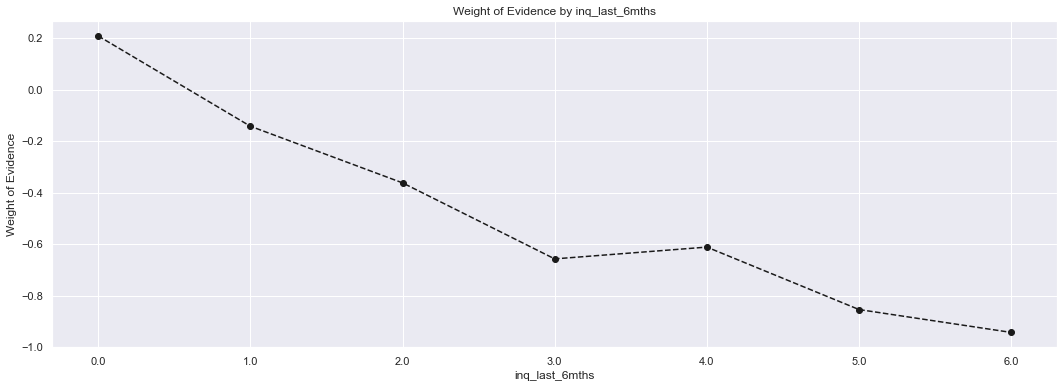

In [94]:
plot_woe(df_temp)

###### inquiry in the past 6 months

In [95]:
sample_input_df['inq_last_6mths:0'] = np.where((sample_input_df['inq_last_6mths'] == 0), 1, 0)
sample_input_df['inq_last_6mths:1-2'] = np.where((sample_input_df['inq_last_6mths'] >= 1) & (sample_input_df['inq_last_6mths'] <= 2), 1, 0)
sample_input_df['inq_last_6mths:3-6'] = np.where((sample_input_df['inq_last_6mths'] >= 3) & (sample_input_df['inq_last_6mths'] <= 6), 1, 0)
sample_input_df['inq_last_6mths:>6'] = np.where((sample_input_df['inq_last_6mths'] > 6), 1, 0)

###### number of open accounts

In [96]:
# do the same for continuous variable open_acc. 
sample_input_df['open_acc'].unique()

array([17., 15.,  6., 10.,  7.,  9.,  5., 30., 12., 21., 18., 13.,  8.,
       16.,  4., 11., 33., 14.,  3., 28., 19., 24., 20., 22., 29., 27.,
       23., 25., 26., 34., 46.,  2., 35., 32., 40., 55., 37., 39., 31.,
       36., 38., 47., 44.,  1., 42., 41., 43., 52., 45., 53., 65., 51.,
       58., 67., 49., 50., 57., 48., 66., 54., 68., 61., 70., 60., 56.,
       82., 63., 59., 64., 62., 79., 74., 90.])

In [97]:
df_temp = woe_continuous(sample_input_df, 'open_acc', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,open_acc,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,1.0,90,0.988889,0.000214,89.0,1.0,0.000215,0.000127,0.525241,NaN,NaN,inf
1,2.0,986,0.972617,0.002342,959.0,27.0,0.002321,0.003439,-0.393341,0.016272,0.918582,inf
2,3.0,4119,0.984462,0.009782,4055.0,64.0,0.009813,0.008152,0.185428,0.011846,0.578769,inf
3,4.0,10779,0.978941,0.025598,10552.0,227.0,0.025535,0.028914,-0.124274,0.005522,0.309702,inf
4,5.0,18222,0.980738,0.043273,17871.0,351.0,0.043246,0.044708,-0.033247,0.001797,0.091028,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
68,70.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf
69,74.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf
70,79.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf
71,82.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf


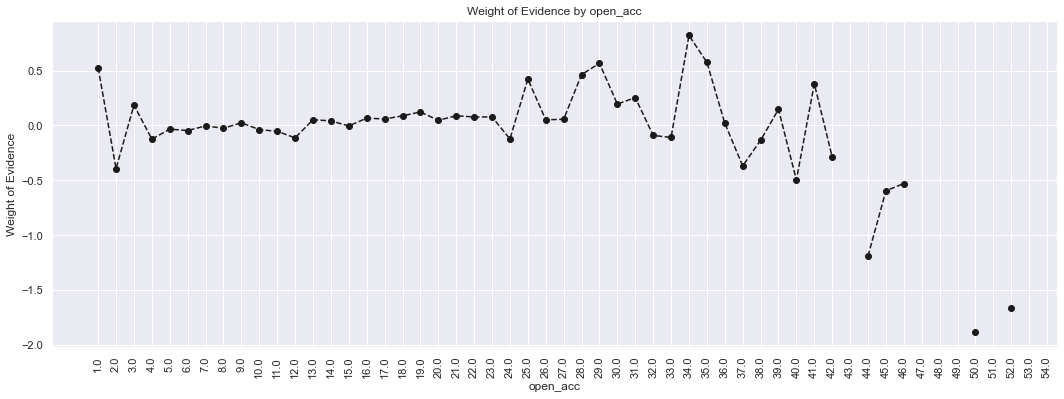

In [98]:
plot_woe(df_temp, 90)

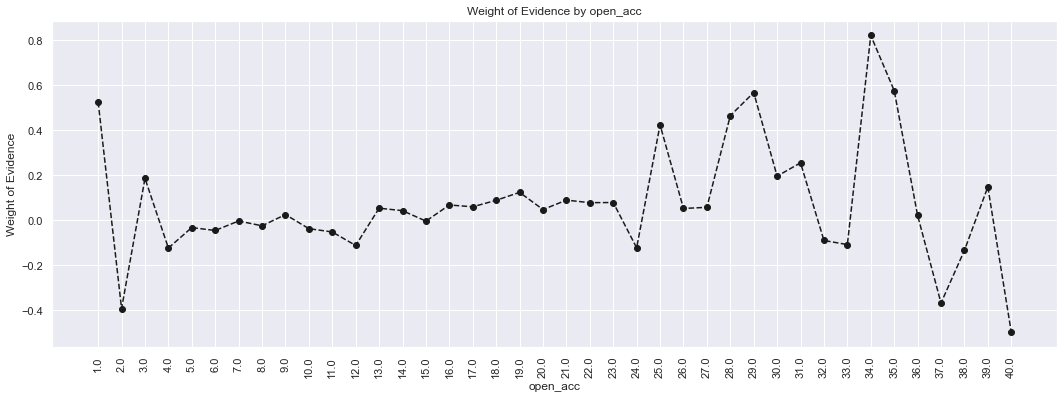

In [99]:
plot_woe(df_temp.iloc[ : 40, :], 90)

In [100]:
sample_input_df['open_acc:0'] = np.where((sample_input_df['open_acc'] == 0), 1, 0)
sample_input_df['open_acc:1-3'] = np.where((sample_input_df['open_acc'] >= 1) & (sample_input_df['open_acc'] <= 3), 1, 0)
sample_input_df['open_acc:4-12'] = np.where((sample_input_df['open_acc'] >= 4) & (sample_input_df['open_acc'] <= 12), 1, 0)
sample_input_df['open_acc:13-17'] = np.where((sample_input_df['open_acc'] >= 13) & (sample_input_df['open_acc'] <= 17), 1, 0)
sample_input_df['open_acc:18-22'] = np.where((sample_input_df['open_acc'] >= 18) & (sample_input_df['open_acc'] <= 22), 1, 0)
sample_input_df['open_acc:23-25'] = np.where((sample_input_df['open_acc'] >= 23) & (sample_input_df['open_acc'] <= 25), 1, 0)
sample_input_df['open_acc:26-30'] = np.where((sample_input_df['open_acc'] >= 26) & (sample_input_df['open_acc'] <= 30), 1, 0)
sample_input_df['open_acc:>=31'] = np.where((sample_input_df['open_acc'] >= 31), 1, 0)

###### deprecated public record

In [101]:
# do the same for continuous variable pub_rec. 
sample_input_df['pub_rec'].unique()

array([ 0.,  2.,  1.,  3.,  5.,  4., 11.,  7.,  6.,  9.,  8., 10., 23.,
       12., 15., 26., 17., 13., 28., 20., 86., 18., 21., 14., 16., 19.,
       49., 22.])

In [102]:
df_temp = woe_continuous(sample_input_df, 'pub_rec', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,pub_rec,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,346679,0.981594,0.823282,340298.0,6381.0,0.823482,0.812763,0.013102,NaN,NaN,inf
1,1.0,60215,0.979972,0.142997,59009.0,1206.0,0.142795,0.153611,-0.073014,0.001622,0.086116,inf
2,2.0,9230,0.982124,0.021919,9065.0,165.0,0.021936,0.021016,0.042836,0.002152,0.115850,inf
3,3.0,2876,0.979833,0.006830,2818.0,58.0,0.006819,0.007388,-0.080055,0.002290,0.122891,inf
4,4.0,1044,0.977011,0.002479,1020.0,24.0,0.002468,0.003057,-0.213891,0.002822,0.133836,inf
5,5.0,481,0.979210,0.001142,471.0,10.0,0.001140,0.001274,-0.111122,0.002198,0.102769,inf
6,6.0,249,0.983936,0.000591,245.0,4.0,0.000593,0.000509,0.151569,0.004726,0.262691,inf
7,7.0,108,1.000000,0.000256,108.0,0.0,0.000261,0.000000,inf,0.016064,inf,inf
8,8.0,84,1.000000,0.000199,84.0,0.0,0.000203,0.000000,inf,0.000000,NaN,inf
9,9.0,34,0.970588,0.000081,33.0,1.0,0.000080,0.000127,-0.466887,0.029412,inf,inf


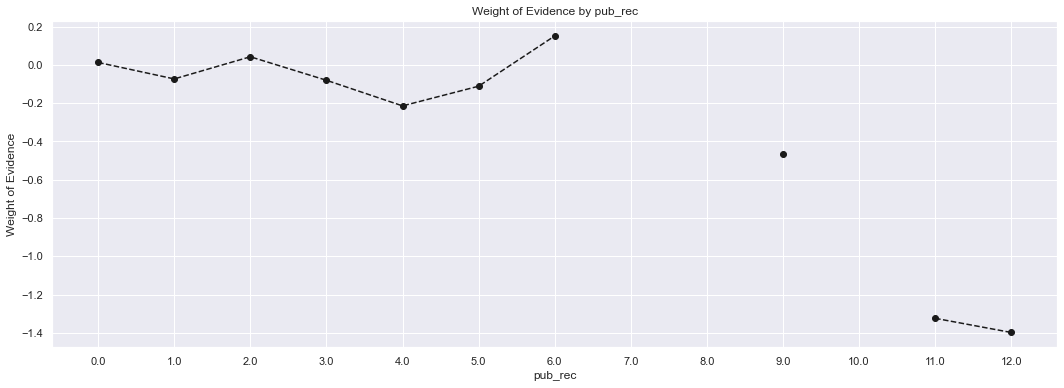

In [103]:
plot_woe(df_temp)

In [104]:
sample_input_df['pub_rec:0-2'] = np.where((sample_input_df['pub_rec'] >= 0) & (sample_input_df['pub_rec'] <= 2), 1, 0)
sample_input_df['pub_rec:3-4'] = np.where((sample_input_df['pub_rec'] >= 3) & (sample_input_df['pub_rec'] <= 4), 1, 0)
sample_input_df['pub_rec:>=5'] = np.where((sample_input_df['pub_rec'] >= 5), 1, 0)

###### total accounts

In [105]:
# do the same for continuous variable delinq_2yrs. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['total_acc'].unique()

array([ 46.,  24.,   6.,  23.,  18.,  31.,  19.,  13.,  47.,  21.,  35.,
        33.,  22.,  17.,  32.,   7.,  14.,   9.,  72.,  20.,  39.,  37.,
        34.,  27.,  26.,   5.,  69.,  15.,  28.,  25.,  29.,  16.,  38.,
        12.,  10.,  63.,  44.,  43.,  48.,  11.,  36.,  42.,  30.,  49.,
        54.,  53.,  52.,  56.,  40.,  41.,  62.,  45.,  68.,  64.,  58.,
        61.,  65.,   8.,  87.,  50.,   4.,  66.,  59.,  60.,  51.,  89.,
        70.,  71.,  57.,  55.,  77.,  75.,  73.,  67.,  76., 105.,  74.,
       102.,  98.,  85.,  81.,  78.,  83.,  79., 111.,  84.,  86.,  94.,
        97.,  90.,  82.,  93., 127.,  96., 101.,  91.,  80., 112., 125.,
       110.,  95.,  88.,  92., 109., 135.,  99., 106., 104., 151., 130.,
       107., 113., 169., 140., 146., 100., 116., 129., 126., 137., 103.,
       124., 138., 162., 114., 108.])

In [106]:
sample_input_df['total_acc_factor'] = pd.cut(sample_input_df['total_acc'], 50)
df_temp = woe_continuous(sample_input_df, 'total_acc_factor', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_acc_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(3.835, 7.3]",11333,0.976970,0.026913,11072.0,261.0,0.026793,0.033244,-0.215741,NaN,NaN,inf
1,"(7.3, 10.6]",21005,0.979767,0.049882,20580.0,425.0,0.049801,0.054133,-0.083409,0.002797,0.132332,inf
2,"(10.6, 13.9]",31446,0.979457,0.074677,30800.0,646.0,0.074532,0.082283,-0.098924,0.000310,0.015515,inf
3,"(13.9, 17.2]",53180,0.980557,0.126290,52146.0,1034.0,0.126187,0.131703,-0.042782,0.001100,0.056142,inf
4,"(17.2, 20.5]",44528,0.981742,0.105744,43715.0,813.0,0.105785,0.103554,0.021321,0.001185,0.064103,inf
5,"(20.5, 23.8]",44749,0.981676,0.106268,43929.0,820.0,0.106303,0.104445,0.017631,0.000066,0.003690,inf
6,"(23.8, 27.1]",55586,0.981182,0.132004,54540.0,1046.0,0.131980,0.133231,-0.009434,0.000493,0.027065,inf
7,"(27.1, 30.4]",35493,0.982363,0.084288,34867.0,626.0,0.084374,0.079735,0.056551,0.001180,0.065985,inf
8,"(30.4, 33.7]",29540,0.982668,0.070151,29028.0,512.0,0.070244,0.065215,0.074297,0.000305,0.017746,inf
9,"(33.7, 37.0]",30463,0.982405,0.072343,29927.0,536.0,0.072420,0.068272,0.058987,0.000263,0.015309,inf


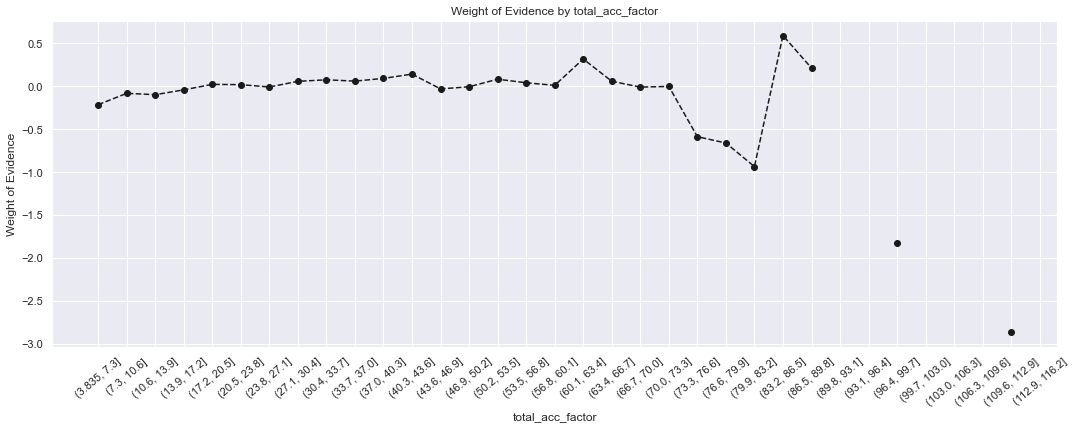

In [107]:
plot_woe(df_temp, 40)

In [108]:
sample_input_df['total_acc:<=27'] = np.where((sample_input_df['total_acc'] <= 27), 1, 0)
sample_input_df['total_acc:28-51'] = np.where((sample_input_df['total_acc'] >= 28) & (sample_input_df['total_acc'] <= 51), 1, 0)
sample_input_df['total_acc:>=52'] = np.where((sample_input_df['total_acc'] >= 52), 1, 0)

###### account delinquent now

In [109]:
# do the same for continuous variable acc_now_delinq. 
sample_input_df['acc_now_delinq'].unique()

array([ 0.,  1.,  2.,  4.,  3.,  5.,  6., 14.])

In [110]:
df_temp = woe_continuous(sample_input_df, 'acc_now_delinq', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,acc_now_delinq,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,0.0,418712,0.981424,0.994343,410934.0,7778.0,0.994412,0.990702,0.003738,NaN,NaN,inf
1,1.0,2243,0.971021,0.005327,2178.0,65.0,0.005271,0.008279,-0.451620,0.010403,0.455358,inf
2,2.0,116,0.939655,0.000275,109.0,7.0,0.000264,0.000892,-1.217957,0.031366,0.766337,inf
3,3.0,17,1.000000,0.000040,17.0,0.0,0.000041,0.000000,inf,0.060345,inf,inf
4,4.0,3,0.666667,0.000007,2.0,1.0,0.000005,0.000127,-3.270248,0.333333,inf,inf
5,5.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.333333,inf,inf
6,6.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf
7,14.0,1,1.000000,0.000002,1.0,0.0,0.000002,0.000000,inf,0.000000,NaN,inf


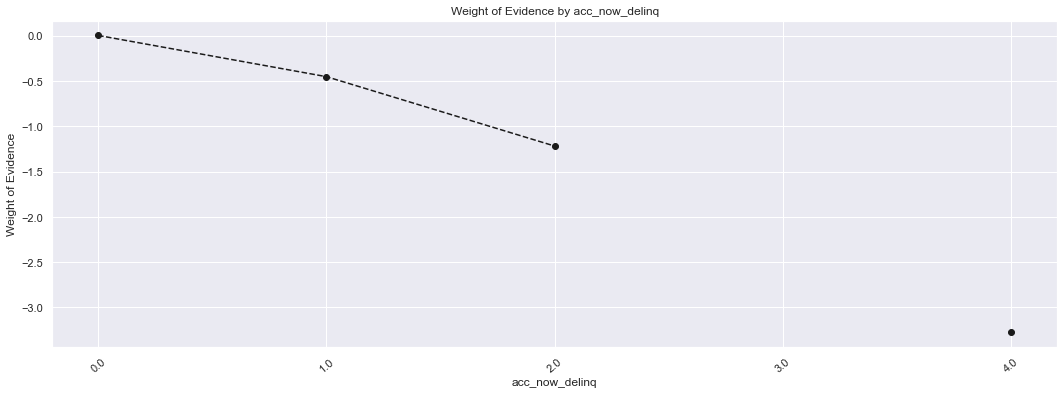

In [111]:
plot_woe(df_temp, 40)

In [112]:
sample_input_df['acc_now_delinq:0'] = np.where((sample_input_df['acc_now_delinq'] == 0), 1, 0)
sample_input_df['acc_now_delinq:>=1'] = np.where((sample_input_df['acc_now_delinq'] >= 1), 1, 0)

###### total revolving limit

In [113]:
# do the same for continuous variable total_rev_hi_lim. Cut by 2000 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['total_rev_hi_lim'].unique()

array([ 52200.,  26800.,   4300., ..., 318000.,  44408., 328100.])

In [114]:
sample_input_df['total_rev_hi_lim_factor'] = pd.cut(sample_input_df['total_rev_hi_lim'], 2000)
df_temp = woe_continuous(sample_input_df, 'total_rev_hi_lim_factor', sample_target_df)
df_temp

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,total_rev_hi_lim_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-9999.999, 5000.0]",12981,0.971266,0.030827,12608.0,373.0,0.030510,0.047510,-0.442886,NaN,NaN,inf
1,"(5000.0, 9999.999]",42858,0.974801,0.101778,41778.0,1080.0,0.101098,0.137562,-0.307986,0.003535,0.134900,inf
2,"(9999.999, 14999.998]",56173,0.977658,0.133398,54918.0,1255.0,0.132895,0.159852,-0.184689,0.002858,0.123297,inf
3,"(14999.998, 19999.998]",54873,0.979498,0.130311,53748.0,1125.0,0.130064,0.143294,-0.096871,0.001840,0.087818,inf
4,"(19999.998, 24999.997]",46739,0.981942,0.110994,45895.0,844.0,0.111061,0.107502,0.032564,0.002444,0.129436,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


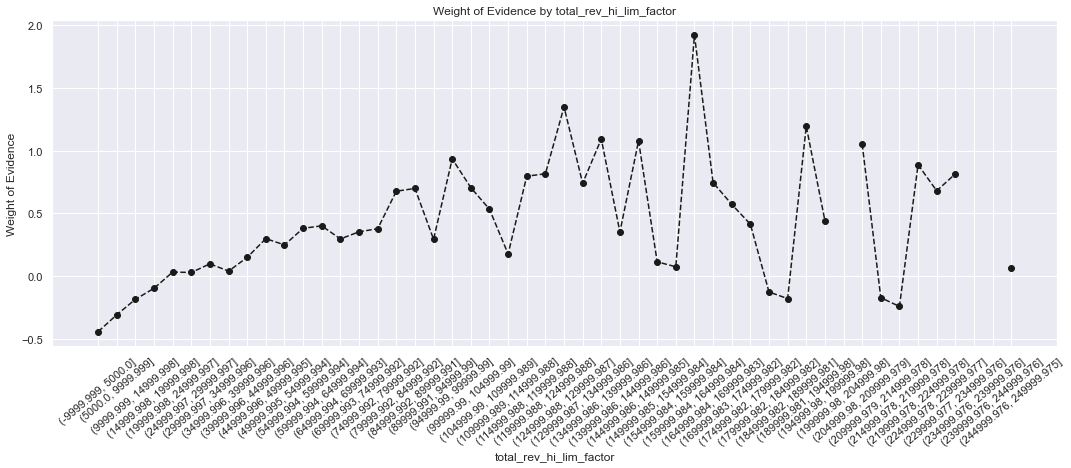

In [115]:
plot_woe(df_temp.iloc[: 50, :], 40)

In [116]:
sample_input_df['total_rev_hi_lim:<=5K'] = np.where((sample_input_df['total_rev_hi_lim'] <= 5000), 1, 0)
sample_input_df['total_rev_hi_lim:5K-10K'] = np.where((sample_input_df['total_rev_hi_lim'] > 5000) & (sample_input_df['total_rev_hi_lim'] <= 10000), 1, 0)
sample_input_df['total_rev_hi_lim:10K-20K'] = np.where((sample_input_df['total_rev_hi_lim'] > 10000) & (sample_input_df['total_rev_hi_lim'] <= 20000), 1, 0)
sample_input_df['total_rev_hi_lim:20K-30K'] = np.where((sample_input_df['total_rev_hi_lim'] > 20000) & (sample_input_df['total_rev_hi_lim'] <= 30000), 1, 0)
sample_input_df['total_rev_hi_lim:30K-40K'] = np.where((sample_input_df['total_rev_hi_lim'] > 30000) & (sample_input_df['total_rev_hi_lim'] <= 40000), 1, 0)
sample_input_df['total_rev_hi_lim:40K-55K'] = np.where((sample_input_df['total_rev_hi_lim'] > 40000) & (sample_input_df['total_rev_hi_lim'] <= 55000), 1, 0)
sample_input_df['total_rev_hi_lim:55K-95K'] = np.where((sample_input_df['total_rev_hi_lim'] > 55000) & (sample_input_df['total_rev_hi_lim'] <= 95000), 1, 0)
sample_input_df['total_rev_hi_lim:>95K'] = np.where((sample_input_df['total_rev_hi_lim'] > 95000), 1, 0)

###### number of monthly installment

In [117]:
# do the same for continuous variable installment. Cut by 50 equal range, compute WoE for them and manually create dummy variables coarse classing
sample_input_df['installment'].unique()

array([778.38, 260.5 , 146.16, ..., 459.22, 237.86, 220.37])

In [118]:
sample_input_df['installment_factor'] = pd.cut(sample_input_df['installment'], 50)
df_temp = woe_continuous(sample_input_df, 'installment_factor', sample_target_df)
df_temp

,installment_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(28.705, 58.427]",3506,0.982886,0.008326,3446.0,60.0,0.008339,0.007642,0.087230,NaN,NaN,inf
1,"(58.427, 86.734]",5832,0.981310,0.013850,5723.0,109.0,0.013849,0.013884,-0.002494,0.001576,0.089724,inf
2,"(86.734, 115.04]",8123,0.983134,0.019290,7986.0,137.0,0.019325,0.017450,0.102069,0.001824,0.104564,inf
3,"(115.04, 143.347]",9139,0.982383,0.021703,8978.0,161.0,0.021726,0.020507,0.057733,0.000751,0.044336,inf
4,"(143.347, 171.654]",17953,0.984459,0.042634,17674.0,279.0,0.042769,0.035537,0.185243,0.002076,0.127510,inf
5,"(171.654, 199.961]",15515,0.985691,0.036845,15293.0,222.0,0.037007,0.028277,0.269078,0.001232,0.083835,inf
6,"(199.961, 228.268]",16515,0.982864,0.039219,16232.0,283.0,0.039280,0.036046,0.085898,0.002827,0.183180,inf
7,"(228.268, 256.574]",22043,0.983033,0.052347,21669.0,374.0,0.052436,0.047637,0.095987,0.000169,0.010089,inf
8,"(256.574, 284.881]",25323,0.980966,0.060136,24841.0,482.0,0.060112,0.061393,-0.021088,0.002067,0.117075,inf
9,"(284.881, 313.188]",24135,0.980443,0.057315,23663.0,472.0,0.057262,0.060120,-0.048706,0.000523,0.027618,inf


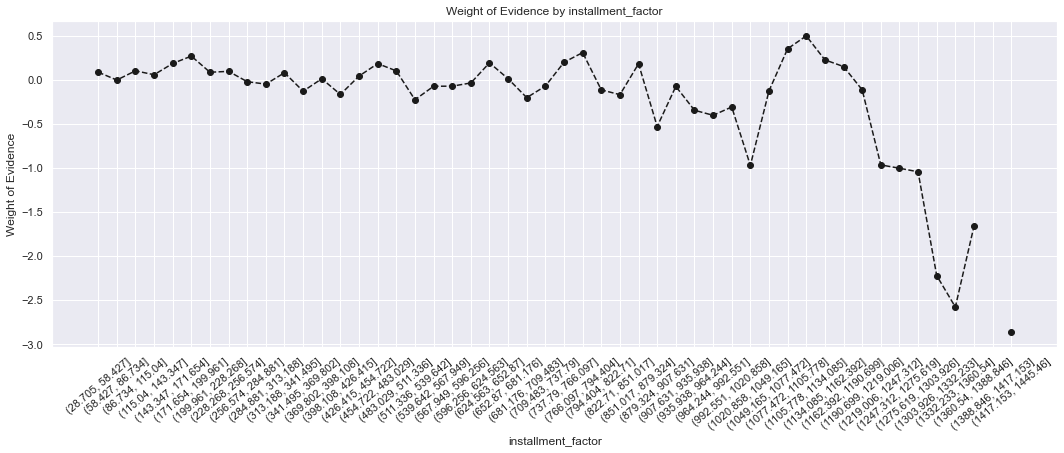

In [119]:
plot_woe(df_temp, 40)

###### annual income

In [120]:
#NOTE: if we fine classing into 50 equal categories, 94% of the observations fall into the first class. Because the range of values of annual income span widely, can be over 1m
# --> can split into high income and low income people --> assuming the threshold of high income vs low income is 140,000
sample_input_df_lowincome = sample_input_df.loc[sample_input_df['annual_inc'] <= 140000, :]     # loc different than iloc in a way that: loc allows to specify condition of the column values that meets the criteria
sample_input_df_lowincome['annual_inc_factor'] = pd.cut(sample_input_df_lowincome['annual_inc'], 50)    # split the new dataframe into 50 equal slices


<ipython-input-120-71e25a301440>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_lowincome['annual_inc_factor'] = pd.cut(sample_input_df_lowincome['annual_inc'], 50)    # split the new dataframe into 50 equal slices


In [121]:
df_temp = woe_continuous(sample_input_df_lowincome, 'annual_inc_factor', sample_target_df[sample_input_df_lowincome.index])
df_temp

,annual_inc_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-140.0, 2800.0]",4,1.000000,0.000010,4.0,0.0,0.000010,0.000000,inf,NaN,NaN,inf
1,"(2800.0, 5600.0]",12,0.916667,0.000031,11.0,1.0,0.000029,0.000135,-1.547375,0.083333,inf,inf
2,"(5600.0, 8400.0]",55,0.981818,0.000141,54.0,1.0,0.000141,0.000135,0.043714,0.065152,1.591089,inf
3,"(8400.0, 11200.0]",429,0.965035,0.001097,414.0,15.0,0.001079,0.002022,-0.627454,0.016783,0.671168,inf
4,"(11200.0, 14000.0]",873,0.977090,0.002233,853.0,20.0,0.002224,0.002695,-0.192243,0.012056,0.435212,inf
5,"(14000.0, 16800.0]",1339,0.973114,0.003425,1303.0,36.0,0.003397,0.004852,-0.356364,0.003976,0.164122,inf
6,"(16800.0, 19600.0]",1808,0.966814,0.004624,1748.0,60.0,0.004558,0.008086,-0.573387,0.006300,0.217023,inf
7,"(19600.0, 22400.0]",3823,0.972273,0.009778,3717.0,106.0,0.009691,0.014286,-0.388037,0.005459,0.185350,inf
8,"(22400.0, 25200.0]",6445,0.973933,0.016485,6277.0,168.0,0.016366,0.022642,-0.324587,0.001660,0.063450,inf
9,"(25200.0, 28000.0]",5904,0.977134,0.015101,5769.0,135.0,0.015041,0.018194,-0.190291,0.003201,0.134296,inf


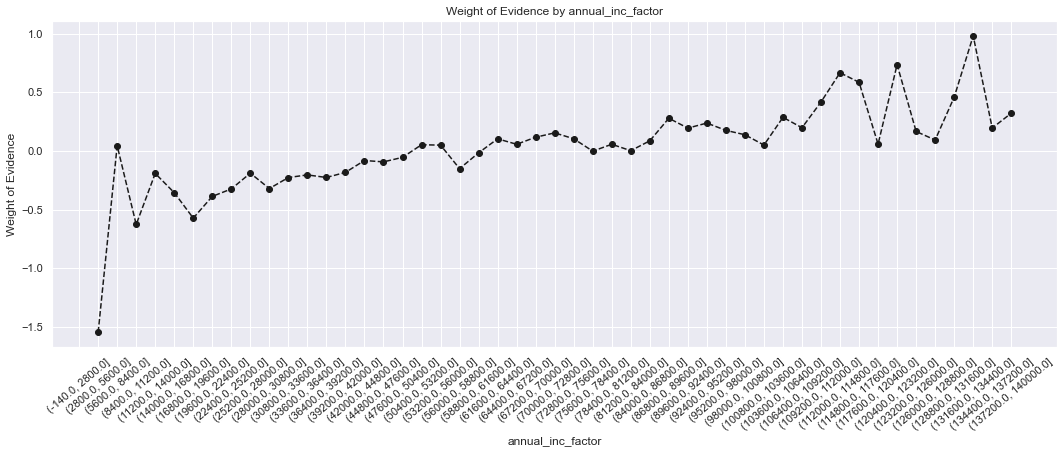

In [122]:
plot_woe(df_temp, 40)

In [123]:
#finally, split the annual income into smaller chunk, especially for the low income. And one big chunk for the high income.
sample_input_df['annual_inc:<20k'] = np.where(sample_input_df['annual_inc'] <= 20000, 1, 0)
sample_input_df['annual_inc:20k-30k'] = np.where((sample_input_df['annual_inc'] > 20000) & (sample_input_df['annual_inc'] <= 30000), 1, 0)
sample_input_df['annual_inc:30k-40k'] = np.where((sample_input_df['annual_inc'] > 30000) & (sample_input_df['annual_inc'] <= 40000), 1, 0)
sample_input_df['annual_inc:40k-50k'] = np.where((sample_input_df['annual_inc'] > 40000) & (sample_input_df['annual_inc'] <= 50000), 1, 0)
sample_input_df['annual_inc:50k-60k'] = np.where((sample_input_df['annual_inc'] > 50000) & (sample_input_df['annual_inc'] <= 60000), 1, 0)
sample_input_df['annual_inc:60k-70k'] = np.where((sample_input_df['annual_inc'] > 60000) & (sample_input_df['annual_inc'] <= 70000), 1, 0)
sample_input_df['annual_inc:70k-80k'] = np.where((sample_input_df['annual_inc'] > 70000) & (sample_input_df['annual_inc'] <= 80000), 1, 0)
sample_input_df['annual_inc:80k-90k'] = np.where((sample_input_df['annual_inc'] > 80000) & (sample_input_df['annual_inc'] <= 90000), 1, 0)
sample_input_df['annual_inc:90k-100k'] = np.where((sample_input_df['annual_inc'] > 90000) & (sample_input_df['annual_inc'] <= 100000), 1, 0)
sample_input_df['annual_inc:100k-120k'] = np.where((sample_input_df['annual_inc'] > 100000) & (sample_input_df['annual_inc'] <= 120000), 1, 0)
sample_input_df['annual_inc:120k-140k'] = np.where((sample_input_df['annual_inc'] > 120000) & (sample_input_df['annual_inc'] <= 140000), 1, 0)
sample_input_df['annual_inc:>140k'] = np.where(sample_input_df['annual_inc'] > 140000, 1, 0)

###### months since last delinquency

In [124]:
sample_input_df_everDelq = sample_input_df[pd.notnull(sample_input_df['mths_since_last_delinq'])]       #create new subset df where last delq is not null --> i.e. have been delq in the past
sample_input_df_everDelq['mths_since_last_delinq_factor'] = pd.cut(sample_input_df_everDelq['mths_since_last_delinq'], 50)
df_temp = woe_continuous(sample_input_df_everDelq, 'mths_since_last_delinq_factor', sample_target_df[sample_input_df_everDelq.index])
df_temp

<ipython-input-124-3358bb462b54>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_everDelq['mths_since_last_delinq_factor'] = pd.cut(sample_input_df_everDelq['mths_since_last_delinq'], 50)
c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,mths_since_last_delinq_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.176, 3.52]",7261,0.973833,0.033440,7071.0,190.0,0.033183,0.047041,-0.349003,NaN,NaN,inf
1,"(3.52, 7.04]",15763,0.978367,0.072596,15422.0,341.0,0.072372,0.084427,-0.154068,0.004534,0.194935,inf
2,"(7.04, 10.56]",12365,0.980348,0.056947,12122.0,243.0,0.056886,0.060163,-0.056020,0.001981,0.098048,inf
3,"(10.56, 14.08]",16125,0.979721,0.074263,15798.0,327.0,0.074136,0.080961,-0.088058,0.000627,0.032037,inf
4,"(14.08, 17.6]",11384,0.976985,0.052429,11122.0,262.0,0.052193,0.064868,-0.217400,0.002736,0.129343,inf
5,"(17.6, 21.12]",14291,0.983626,0.065817,14057.0,234.0,0.065966,0.057935,0.129818,0.006641,0.347219,inf
6,"(21.12, 24.64]",10544,0.982170,0.048560,10356.0,188.0,0.048598,0.046546,0.043143,0.001456,0.086675,inf
7,"(24.64, 28.16]",13761,0.981760,0.063376,13510.0,251.0,0.063399,0.062144,0.019996,0.000410,0.023147,inf
8,"(28.16, 31.68]",9867,0.985001,0.045442,9719.0,148.0,0.045609,0.036643,0.218889,0.003240,0.198893,inf
9,"(31.68, 35.2]",12583,0.985218,0.057951,12397.0,186.0,0.058176,0.046051,0.233727,0.000218,0.014837,inf


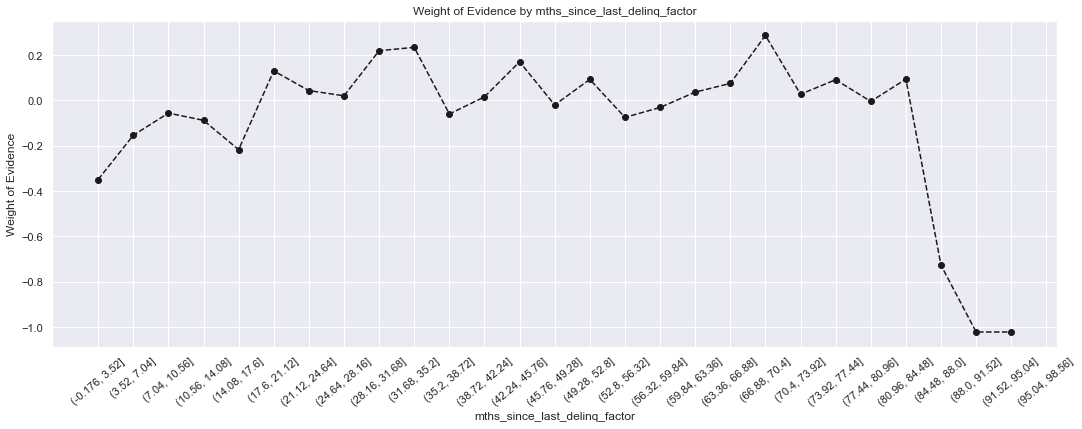

In [125]:
plot_woe(df_temp, 40)

In [126]:
sample_input_df['mths_since_last_delinq:Missing'] = np.where((sample_input_df['mths_since_last_delinq'].isnull()), 1, 0)
sample_input_df['mths_since_last_delinq:0-3'] = np.where((sample_input_df['mths_since_last_delinq'] >=0) & (sample_input_df['mths_since_last_delinq'] <= 3), 1, 0)
sample_input_df['mths_since_last_delinq:4-30'] = np.where((sample_input_df['mths_since_last_delinq'] >= 4) & (sample_input_df['mths_since_last_delinq'] <= 30), 1, 0)
sample_input_df['mths_since_last_delinq:31-56'] = np.where((sample_input_df['mths_since_last_delinq'] >= 31) & (sample_input_df['mths_since_last_delinq'] <= 56), 1, 0)
sample_input_df['mths_since_last_delinq:>56'] = np.where(sample_input_df['mths_since_last_delinq'] > 56, 1, 0)

###### debt to income ratio

In [127]:
sample_input_df['dti_factor'] = pd.cut(sample_input_df['dti'], 50)
df_temp = woe_continuous(sample_input_df, 'dti_factor', sample_target_df)
df_temp

,dti_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-9.999, 199.98]",421089,0.981355,0.999988,413238.0,7851.0,0.999988,1.0,-0.000012,NaN,NaN,inf
1,"(199.98, 399.96]",1,1.000000,0.000002,1.0,0.0,0.000002,0.0,inf,0.018645,inf,inf
2,"(399.96, 599.94]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(599.94, 799.92]",1,1.000000,0.000002,1.0,0.0,0.000002,0.0,inf,NaN,NaN,inf
4,"(799.92, 999.9]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(999.9, 1199.88]",1,1.000000,0.000002,1.0,0.0,0.000002,0.0,inf,NaN,NaN,inf
6,"(1199.88, 1399.86]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
7,"(1399.86, 1599.84]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
8,"(1599.84, 1799.82]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
9,"(1799.82, 1999.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


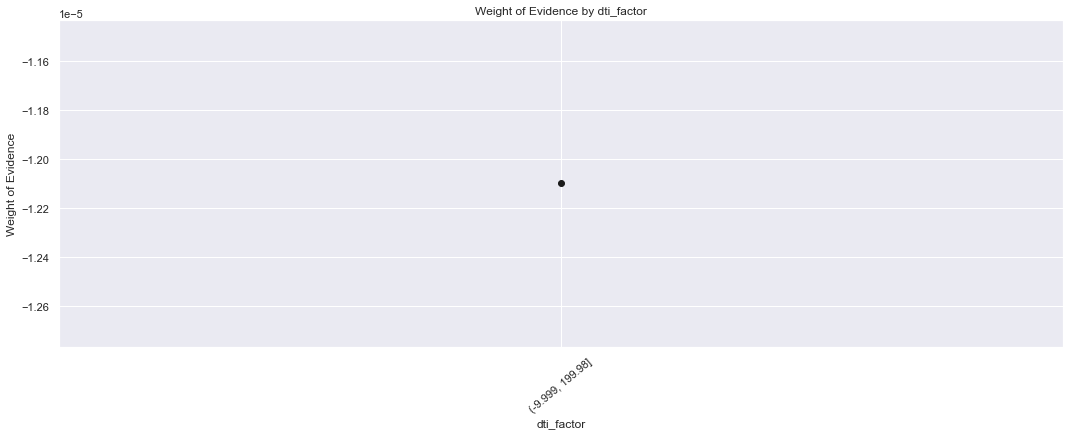

In [128]:
plot_woe(df_temp, 40)
# observation distribution is similar to a bell shape curve. Most observations is below 35

In [129]:
sample_input_df_normDti = sample_input_df.loc[sample_input_df['dti'] <= 35, :] 
sample_input_df_normDti['dti_factor'] = pd.cut(sample_input_df_normDti['dti'], 50)
df_temp = woe_continuous(sample_input_df_normDti, 'dti_factor', sample_target_df[sample_input_df_normDti.index])
df_temp

<ipython-input-129-ebd457e42f40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_normDti['dti_factor'] = pd.cut(sample_input_df_normDti['dti'], 50)


,dti_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.035, 0.7]",707,0.980198,0.001749,693.0,14.0,0.001746,0.001907,-0.088060,NaN,NaN,0.045535
1,"(0.7, 1.4]",1116,0.977599,0.002761,1091.0,25.0,0.002749,0.003406,-0.214059,0.002599,0.125999,0.045535
2,"(1.4, 2.1]",1596,0.981830,0.003949,1567.0,29.0,0.003949,0.003950,-0.000410,0.004231,0.213648,0.045535
3,"(2.1, 2.8]",2140,0.982710,0.005295,2103.0,37.0,0.005299,0.005040,0.050169,0.000881,0.050580,0.045535
4,"(2.8, 3.5]",2873,0.981552,0.007108,2820.0,53.0,0.007106,0.007220,-0.015833,0.001158,0.066002,0.045535
5,"(3.5, 4.2]",3342,0.982944,0.008269,3285.0,57.0,0.008278,0.007765,0.064038,0.001392,0.079870,0.045535
6,"(4.2, 4.9]",3963,0.988140,0.009805,3916.0,47.0,0.009868,0.006402,0.432645,0.005196,0.368608,0.045535
7,"(4.9, 5.6]",4945,0.986653,0.012235,4879.0,66.0,0.012295,0.008991,0.313008,0.001487,0.119638,0.045535
8,"(5.6, 6.3]",5600,0.986071,0.013856,5522.0,78.0,0.013915,0.010625,0.269754,0.000582,0.043254,0.045535
9,"(6.3, 7.0]",6101,0.987543,0.015095,6025.0,76.0,0.015183,0.010353,0.382907,0.001472,0.113153,0.045535


In [130]:
sample_input_df['dti:<=1.4'] = np.where((sample_input_df['dti'] <= 1.4), 1, 0)
sample_input_df['dti:1.4-3.5'] = np.where((sample_input_df['dti'] > 1.4) & (sample_input_df['dti'] <= 3.5), 1, 0)
sample_input_df['dti:3.5-7.7'] = np.where((sample_input_df['dti'] > 3.5) & (sample_input_df['dti'] <= 7.7), 1, 0)
sample_input_df['dti:7.7-10.5'] = np.where((sample_input_df['dti'] > 7.7) & (sample_input_df['dti'] <= 10.5), 1, 0)
sample_input_df['dti:10.5-16.1'] = np.where((sample_input_df['dti'] > 10.5) & (sample_input_df['dti'] <= 16.1), 1, 0)
sample_input_df['dti:16.1-20.3'] = np.where((sample_input_df['dti'] > 16.1) & (sample_input_df['dti'] <= 20.3), 1, 0)
sample_input_df['dti:20.3-21.7'] = np.where((sample_input_df['dti'] > 20.3) & (sample_input_df['dti'] <= 21.7), 1, 0)
sample_input_df['dti:21.7-22.4'] = np.where((sample_input_df['dti'] > 21.7) & (sample_input_df['dti'] <= 22.4), 1, 0)
sample_input_df['dti:22.4-35'] = np.where((sample_input_df['dti'] > 22.4) & (sample_input_df['dti'] <= 35), 1, 0)
sample_input_df['dti:>35'] = np.where((sample_input_df['dti'] > 35), 1, 0)

###### months since last public record

In [131]:
sample_input_df_lastRecord = sample_input_df[pd.notnull(sample_input_df['mths_since_last_record'])]
sample_input_df_lastRecord['mths_since_last_record_factor'] = pd.cut(sample_input_df_lastRecord['mths_since_last_record'],50)
df_temp = woe_continuous(sample_input_df_lastRecord, 'mths_since_last_record_factor', sample_target_df[sample_input_df_lastRecord.index])
df_temp

<ipython-input-131-4c77f39c3833>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input_df_lastRecord['mths_since_last_record_factor'] = pd.cut(sample_input_df_lastRecord['mths_since_last_record'],50)


,mths_since_last_record_factor,n_obs,prcnt_good,prcnt_n_obs,n_good,n_bad,prcnt_n_good,prcnt_n_bad,WoE,diff_prcnt_good,diff_WoE,IV
0,"(-0.12, 2.4]",87,0.965517,0.001169,84.0,3.0,0.001152,0.002041,-0.572239,NaN,NaN,0.060687
1,"(2.4, 4.8]",161,0.968944,0.002164,156.0,5.0,0.002139,0.003401,-0.464025,0.003427,0.108214,0.060687
2,"(4.8, 7.2]",344,0.976744,0.004623,336.0,8.0,0.004606,0.005442,-0.166774,0.007800,0.297252,0.060687
3,"(7.2, 9.6]",291,0.982818,0.003911,286.0,5.0,0.003921,0.003401,0.142111,0.006074,0.308884,0.060687
4,"(9.6, 12.0]",537,0.970205,0.007216,521.0,16.0,0.007142,0.010884,-0.421282,0.012613,0.563393,0.060687
5,"(12.0, 14.4]",404,0.985149,0.005429,398.0,6.0,0.005456,0.004082,0.290249,0.014944,0.711531,0.060687
6,"(14.4, 16.8]",410,0.980488,0.005510,402.0,8.0,0.005511,0.005442,0.012567,0.004661,0.277682,0.060687
7,"(16.8, 19.2]",693,0.987013,0.009313,684.0,9.0,0.009377,0.006122,0.426290,0.006525,0.413723,0.060687
8,"(19.2, 21.6]",521,0.986564,0.007001,514.0,7.0,0.007046,0.004762,0.391870,0.000449,0.034420,0.060687
9,"(21.6, 24.0]",825,0.979394,0.011086,808.0,17.0,0.011077,0.011565,-0.043095,0.007170,0.434964,0.060687


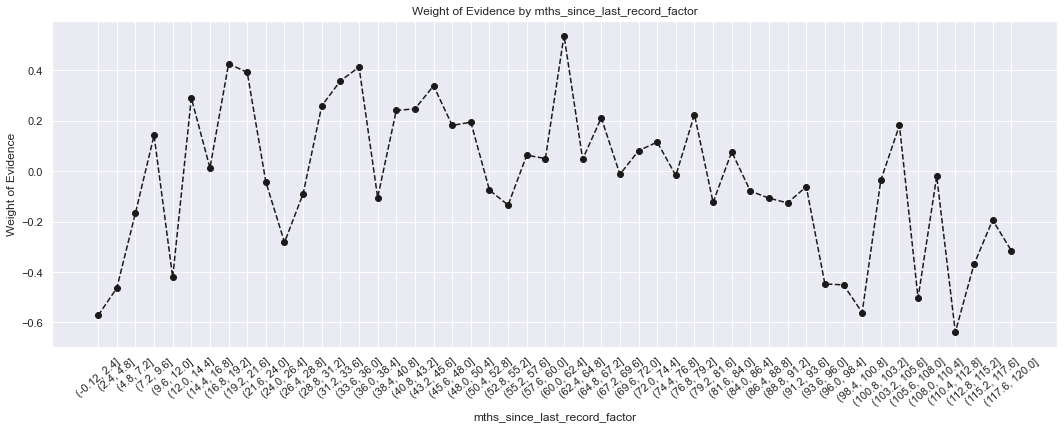

In [132]:
plot_woe(df_temp, 40)

In [133]:
sample_input_df['mths_since_last_record:Missing'] = np.where((sample_input_df['mths_since_last_record'].isnull()), 1, 0)
sample_input_df['mths_since_last_record:0-2'] = np.where((sample_input_df['mths_since_last_record'] >= 0) & (sample_input_df['mths_since_last_record'] <= 2), 1, 0)
sample_input_df['mths_since_last_record:3-20'] = np.where((sample_input_df['mths_since_last_record'] >= 3) & (sample_input_df['mths_since_last_record'] <= 20), 1, 0)
sample_input_df['mths_since_last_record:21-31'] = np.where((sample_input_df['mths_since_last_record'] >= 21) & (sample_input_df['mths_since_last_record'] <= 31), 1, 0)
sample_input_df['mths_since_last_record:32-80'] = np.where((sample_input_df['mths_since_last_record'] >= 32) & (sample_input_df['mths_since_last_record'] <= 80), 1, 0)
sample_input_df['mths_since_last_record:81-86'] = np.where((sample_input_df['mths_since_last_record'] >= 81) & (sample_input_df['mths_since_last_record'] <= 86), 1, 0)
sample_input_df['mths_since_last_record:>86'] = np.where((sample_input_df['mths_since_last_record'] > 86), 1, 0)

In [134]:
# store inputs and targets data into a dataframe
loan_data_inputs_2015 = sample_input_df 
loan_data_targets_2015 = sample_target_df 

In [135]:
# check if inputs and targets df are matching 
print(loan_data_inputs_2015.shape)
print(loan_data_targets_2015.shape)

(421094, 318)
(421094,)


In [136]:
# save new population data (2015) inputs and targets into csv file
loan_data_inputs_2015.to_csv(os.path.join(path_datamart, 'inputs_2015.csv'))
loan_data_targets_2015.to_csv(os.path.join(path_datamart, 'targets_2015.csv'))

## Score card for the train dataset & new population

In [137]:
# similar to the step in "PD model" notebook, compute Score from PD for the training dataset and the 2015 population dataset

In [138]:
inputs_train_with_ref_cat = pd.read_csv('inputs_train_with_ref_cat.csv', index_col=0)   # import coef of train dataset, in the PD model notebook

In [139]:
# create similar file to 2015 new population
inputs_2015_with_ref_cat = loan_data_inputs_2015.loc[:, [
    'grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    'home_ownership:Rent_Other_None_Any',
    'home_ownership:OWN',
    'home_ownership:MORTGAGE',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'addr_state:NM_VA',
    'addr_state:NY',
    'addr_state:OK_TN_MO_LA_MD_NC',
    'addr_state:CA',
    'addr_state:UT_KY_AZ_NJ',
    'addr_state:AR_MI_PA_OH_MN',
    'addr_state:RI_MA_DE_SD_IN',
    'addr_state:GA_WA_OR',
    'addr_state:WI_MT',
    'addr_state:TX',
    'addr_state:IL_CT',
    'addr_state:KS_SC_CO_VT_AK_MS',
    'addr_state:WV_NH_WY_DC_ME_ID',
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    'purpose:educ__sm_b__wedd__ren_en__mov__house',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:oth__med__vacation',
    'purpose:major_purch__car__home_impr',
    'initial_list_status:f',
    'initial_list_status:w',
    'term:36',
    'term:60',
    'emp_length:0',
    'emp_length:1',
    'emp_length:2-4',
    'emp_length:5-6',
    'emp_length:7-9',
    'emp_length:10',
    'mths_since_issue_d:<38',
    'mths_since_issue_d:38-39',
    'mths_since_issue_d:40-41',
    'mths_since_issue_d:42-48',
    'mths_since_issue_d:49-52',
    'mths_since_issue_d:53-64',
    'mths_since_issue_d:65-84',
    'mths_since_issue_d:>84',
    'int_rate:<9.548',
    'int_rate:9.548-12.025',
    'int_rate:12.025-15.74',
    'int_rate:15.74-20.281',
    'int_rate:>20.281',
    'mths_since_earliest_cr_line:<140',
    'mths_since_earliest_cr_line:141-164',
    'mths_since_earliest_cr_line:165-247',
    'mths_since_earliest_cr_line:248-270',
    'mths_since_earliest_cr_line:271-352',
    'mths_since_earliest_cr_line:>352',
    'inq_last_6mths:0',
    'inq_last_6mths:1-2',
    'inq_last_6mths:3-6',
    'inq_last_6mths:>6',
    'acc_now_delinq:0',
    'acc_now_delinq:>=1',
    'annual_inc:<20k',
    'annual_inc:20k-30k',
    'annual_inc:30k-40k',
    'annual_inc:40k-50k',
    'annual_inc:50k-60k',
    'annual_inc:60k-70k',
    'annual_inc:70k-80k',
    'annual_inc:80k-90k',
    'annual_inc:90k-100k',
    'annual_inc:100k-120k',
    'annual_inc:120k-140k',
    'annual_inc:>140k',
    'dti:<=1.4',
    'dti:1.4-3.5',
    'dti:3.5-7.7',
    'dti:7.7-10.5',
    'dti:10.5-16.1',
    'dti:16.1-20.3',
    'dti:20.3-21.7',
    'dti:21.7-22.4',
    'dti:22.4-35',
    'dti:>35',
    'mths_since_last_delinq:Missing',
    'mths_since_last_delinq:0-3',
    'mths_since_last_delinq:4-30',
    'mths_since_last_delinq:31-56',
    'mths_since_last_delinq:>56',
    'mths_since_last_record:Missing',
    'mths_since_last_record:0-2',
    'mths_since_last_record:3-20',
    'mths_since_last_record:21-31',
    'mths_since_last_record:32-80',
    'mths_since_last_record:81-86',
    'mths_since_last_record:>86'
    ]
]

In [140]:
print(inputs_train_with_ref_cat.shape)
print(inputs_2015_with_ref_cat.shape)
# the 2 above df should have similar columns, different only number of observations

(373028, 101)
(421094, 101)


In [141]:
df_scorecard = pd.read_csv('df_scorecard.csv')  # scorecard are coefficients of training dataset, converted into Score. These are exported in the PD model notebook.
df_scorecard

,Unnamed: 0,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Round_Diff,Score - Final
0,0,0,Intercept,-1.418809,NaN,Intercept,312.385589,312.0,-0.385589,312.0
1,1,1,grade:A,1.120328,5.653670e-35,grade,85.728564,86.0,0.271436,86.0
2,2,2,grade:B,0.879963,3.153738e-47,grade,67.335624,67.0,-0.335624,67.0
3,3,3,grade:C,0.686308,4.598326e-34,grade,52.516930,53.0,0.483070,53.0
4,4,4,grade:D,0.498920,9.137948e-21,grade,38.177836,38.0,-0.177836,38.0
...,...,...,...,...,...,...,...,...,...,...
97,97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000,0.0,0.000000,0.0
98,98,13,annual_inc:<20k,0.000000,NaN,annual_inc,0.000000,0.0,0.000000,0.0
99,99,14,dti:>35,0.000000,NaN,dti,0.000000,0.0,0.000000,0.0
100,100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000,0.0,0.000000,0.0


In [142]:
# similar to the step of calculating score for test dataset in the PD model notebook: first, insert intercept value for the input data. Second, use the dot product to compute score
inputs_train_with_ref_cat_w_intercept = inputs_train_with_ref_cat 
inputs_train_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)   
inputs_train_with_ref_cat_w_intercept = inputs_train_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]  # reorder column as the Features of the scorecard df
inputs_train_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20k,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
427211,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
206088,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
136020,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
412305,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36159,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [143]:
# does the same for 2015 new population dataset
inputs_2015_with_ref_cat_w_intercept = inputs_2015_with_ref_cat # copy inputs_test_with_ref_cat. Because the inputs_test_with_ref_cat df does not have value for intercept
inputs_2015_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)   # insert new column in the new df. Name the column Intercept. Set value for it as 1 for all rows. 
inputs_2015_with_ref_cat_w_intercept = inputs_2015_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]  # reorder column as the Features of the scorecard df
inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20k,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
id,,,,,,,,,,,,,,,,,,,,,
68444620,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
68547583,1,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
67849662,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
68506885,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
68341763,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [144]:
# get the final score, and reshape it, in order to use it in the dot product
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(102, 1)

In [145]:
y_score_train = inputs_train_with_ref_cat_w_intercept.dot(scorecard_scores)
y_score_train.head()

,0
427211,688.0
206088,597.0
136020,671.0
412305,526.0
36159,528.0


In [146]:
y_score_2015 = inputs_2015_with_ref_cat_w_intercept.dot(scorecard_scores)
y_score_2015.head()

,0
id,
68444620,746.0
68547583,753.0
67849662,634.0
68506885,624.0
68341763,698.0


In [147]:
# combine score with the inputs dataframe
inputs_train_with_ref_cat_w_intercept = pd.concat([inputs_train_with_ref_cat_w_intercept, y_score_train], axis=1)
inputs_2015_with_ref_cat_w_intercept = pd.concat([inputs_2015_with_ref_cat_w_intercept, y_score_2015], axis=1)

In [148]:
# rename the last column 
inputs_train_with_ref_cat_w_intercept.columns.values[inputs_train_with_ref_cat_w_intercept.shape[1] -1] = 'Score'
inputs_2015_with_ref_cat_w_intercept.columns.values[inputs_2015_with_ref_cat_w_intercept.shape[1] -1] = 'Score'

In [149]:
inputs_train_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20k,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2,Score
427211,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,688.0
206088,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,597.0
136020,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,671.0
412305,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,526.0
36159,1,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,528.0


In [150]:
inputs_2015_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20k,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2,Score
id,,,,,,,,,,,,,,,,,,,,,
68444620,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,746.0
68547583,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,753.0
67849662,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,634.0
68506885,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,624.0
68341763,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,698.0


In [151]:
# categorise Score into smaller subsets --> convert them into dummy variables. Given that we know the Score ranges from 300 to 850. 
inputs_train_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_train_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_train_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_train_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_train_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_train_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_train_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_train_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_train_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_train_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_train_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_train_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_train_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_train_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)

In [152]:
# do the same for 2015 new population dataset
inputs_2015_with_ref_cat_w_intercept['Score:300-350'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 300) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 350), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:350-400'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 350) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 400), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:400-450'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 400) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 450), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:450-500'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 450) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 500), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:500-550'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 500) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 550), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:550-600'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 550) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 600), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:600-650'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 600) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 650), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:650-700'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 650) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 700), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:700-750'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 700) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 750), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:750-800'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 750) & (inputs_2015_with_ref_cat_w_intercept['Score'] < 800), 1, 0)
inputs_2015_with_ref_cat_w_intercept['Score:800-850'] = np.where((inputs_2015_with_ref_cat_w_intercept['Score'] >= 800) & (inputs_2015_with_ref_cat_w_intercept['Score'] <= 850), 1, 0)

# PSI: calculation

In [153]:
# PSI for a single original feature: need proportions of observations by sub categories of all its dummy variable sub categories.
# Need to calculate that for all original independent variable and for credit score. 

In [154]:
PSI_calc_train = inputs_train_with_ref_cat_w_intercept.sum()      # Because each category would have value of 1 for only 1 of its sub categories --> sum by column, gives the number of observations of each orginal independent category 
PSI_calc_train = PSI_calc_train / inputs_train_with_ref_cat_w_intercept.shape[0]    # divide the column sum above by the total number of row of the df --> to get proportion of each original category
PSI_calc_train

Intercept        1.000000
grade:A          0.160200
grade:B          0.294160
grade:C          0.268733
grade:D          0.164862
                   ...   
Score:600-650    0.274701
Score:650-700    0.141941
Score:700-750    0.053575
Score:750-800    0.003825
Score:800-850    0.000000
Length: 114, dtype: float64

In [155]:
PSI_calc_2015 = inputs_2015_with_ref_cat_w_intercept.sum() / inputs_2015_with_ref_cat_w_intercept.shape[0]  # do the same for 2015 new population df
PSI_calc_2015

Intercept        1.000000
grade:A          0.174154
grade:B          0.279287
grade:C          0.286318
grade:D          0.148789
                   ...   
Score:600-650    0.309337
Score:650-700    0.268273
Score:700-750    0.207160
Score:750-800    0.036139
Score:800-850    0.000052
Length: 114, dtype: float64

In [156]:
PSI_calc = pd.concat([PSI_calc_train, PSI_calc_2015], axis=1)
PSI_calc.reset_index(inplace=True)
PSI_calc

,index,0,1
0,Intercept,1.000000,1.000000
1,grade:A,0.160200,0.174154
2,grade:B,0.294160,0.279287
3,grade:C,0.268733,0.286318
4,grade:D,0.164862,0.148789
...,...,...,...
109,Score:600-650,0.274701,0.309337
110,Score:650-700,0.141941,0.268273
111,Score:700-750,0.053575,0.207160
112,Score:750-800,0.003825,0.036139


In [157]:
PSI_calc['Original feature name'] = PSI_calc['index'].str.split(':').str[0]  # retrieve the name of the original variable
PSI_calc.columns = ['index','Proportion_Train', 'Proportion_New', 'Original feature name']  # rename columns
PSI_calc = PSI_calc[np.array(['index','Original feature name','Proportion_Train', 'Proportion_New', ])]    # reorder columns
PSI_calc

,index,Original feature name,Proportion_Train,Proportion_New
0,Intercept,Intercept,1.000000,1.000000
1,grade:A,grade,0.160200,0.174154
2,grade:B,grade,0.294160,0.279287
3,grade:C,grade,0.268733,0.286318
4,grade:D,grade,0.164862,0.148789
...,...,...,...,...
109,Score:600-650,Score,0.274701,0.309337
110,Score:650-700,Score,0.141941,0.268273
111,Score:700-750,Score,0.053575,0.207160
112,Score:750-800,Score,0.003825,0.036139


In [158]:
PSI_calc = PSI_calc[(PSI_calc['index'] != 'Intercept') & (PSI_calc['index'] != 'Score')]     # remove the row Intercept and Score
PSI_calc

,index,Original feature name,Proportion_Train,Proportion_New
1,grade:A,grade,0.160200,0.174154
2,grade:B,grade,0.294160,0.279287
3,grade:C,grade,0.268733,0.286318
4,grade:D,grade,0.164862,0.148789
5,grade:E,grade,0.076702,0.082993
...,...,...,...,...
109,Score:600-650,Score,0.274701,0.309337
110,Score:650-700,Score,0.141941,0.268273
111,Score:700-750,Score,0.053575,0.207160
112,Score:750-800,Score,0.003825,0.036139


In [159]:
# due to mathematical reason, anytime the proportion of Train or porportion of New is 0, we have to set the Contribution value to 0 first. 
# Only if it's not the case, then the compute PSI 
PSI_calc['Contribution'] = np.where(
    (PSI_calc['Proportion_Train'] == 0) | (PSI_calc['Proportion_New'] == 0), 
    0,
    (PSI_calc['Proportion_New'] - PSI_calc['Proportion_Train']) * np.log(PSI_calc['Proportion_New'] / PSI_calc['Proportion_Train'])
)
PSI_calc

c:\Users\DDD\anaconda3\envs\CreditRiskModeling\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-159-c1e04fc03063>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PSI_calc['Contribution'] = np.where(


,index,Original feature name,Proportion_Train,Proportion_New,Contribution
1,grade:A,grade,0.160200,0.174154,0.001165
2,grade:B,grade,0.294160,0.279287,0.000772
3,grade:C,grade,0.268733,0.286318,0.001115
4,grade:D,grade,0.164862,0.148789,0.001649
5,grade:E,grade,0.076702,0.082993,0.000496
...,...,...,...,...,...
109,Score:600-650,Score,0.274701,0.309337,0.004113
110,Score:650-700,Score,0.141941,0.268273,0.080422
111,Score:700-750,Score,0.053575,0.207160,0.207710
112,Score:750-800,Score,0.003825,0.036139,0.072567


In [160]:
PSI_calc.groupby('Original feature name')['Contribution'].sum()

Original feature name
Score                          0.991128
acc_now_delinq                 0.000925
addr_state                     0.003837
annual_inc                     0.005445
dti                            0.078143
emp_length                     0.007619
grade                          0.006775
home_ownership                 0.004275
initial_list_status            0.333717
inq_last_6mths                 0.046465
int_rate                       0.079230
mths_since_earliest_cr_line    0.033475
mths_since_issue_d             2.388305
mths_since_last_delinq         0.011594
mths_since_last_record         0.056276
purpose                        0.011645
term                           0.013099
verification_status            0.048219
Name: Contribution, dtype: float64

# PSI: interpretation

In [161]:
# Population Stability Index (PSI) determines whether the new data is too different than from the original ones.
# PSI = 0 --> no difference between 2 populations
# PSI < 0.1 --> little to no difference between 2 populations
# 0.1 < PSI < 0.25 --> little difference between 2 populations, investigate the reason, but no action for the model
# PSI > 0.25 --> big difference between 2 populations, investigation is required, model might have to be redeveloped
# PSI = 1 --> 2 populations are absolutely different

In [162]:
# initial_list_status & mths_since_issue_d have very high PSI --> indicates difference in the 2 populations

## initial_list_status

In [163]:
PSI_calc.iloc[25:30, :]
#NOTE: in the train dataset, 35% of population belongs in status w. While in the new dataset, 63% belongs to status w. However, this is refered to the strategy of the bank, offering different kind of product, rather than different characteristic of the customer. 

,index,Original feature name,Proportion_Train,Proportion_New,Contribution
26,purpose:oth__med__vacation,purpose,0.065837,0.060298,0.000487
27,purpose:major_purch__car__home_impr,purpose,0.089538,0.085983,0.000144
28,initial_list_status:w,initial_list_status,0.349877,0.634659,0.169589
29,term:36,term,0.724929,0.672467,0.003941
30,emp_length:1,emp_length,0.063411,0.065242,0.000052


## mths_since_issue_d

In [164]:
PSI_calc.iloc[90:95, :]
#NOTE: it is natural that the months since issue date were lower for all of the loans that issued since 2015. 

,index,Original feature name,Proportion_Train,Proportion_New,Contribution
91,term:60,term,0.275071,0.327533,0.009158
92,emp_length:0,emp_length,0.122565,0.138109,0.001856
93,mths_since_issue_d:>84,mths_since_issue_d,0.041812,0.000000,0.000000
94,int_rate:>20.281,int_rate,0.078922,0.043860,0.020598
95,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line,0.081637,0.123656,0.017447


## score

In [165]:
PSI_calc.iloc[100:, :]
#NOTE: there are big difference in the outcome of the model --> action need to be taken

,index,Original feature name,Proportion_Train,Proportion_New,Contribution
101,mths_since_last_record:0-2,mths_since_last_record,0.002911,0.000207,0.007155
103,Score:300-350,Score,0.000000,0.000000,0.000000
104,Score:350-400,Score,0.000035,0.000000,0.000000
105,Score:400-450,Score,0.001533,0.000000,0.000000
106,Score:450-500,Score,0.035810,0.000164,0.192023
107,Score:500-550,Score,0.172671,0.020342,0.325783
108,Score:550-600,Score,0.315909,0.158532,0.108511
109,Score:600-650,Score,0.274701,0.309337,0.004113
110,Score:650-700,Score,0.141941,0.268273,0.080422
111,Score:700-750,Score,0.053575,0.207160,0.207710


# The End